# Overview
In this Notebook, we are going to setup the framework for using a feature-based, [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning) model to classify our gesture sets. While in the last assignment you built up familiarity with the SciPy libraries and an initial understanding of shape-based gesture classification, in this Notebook you will begin to learn:
- How to use [Scikit-learn](https://scikit-learn.org/), one of the most popular open-source machine learning libraries in the world
- How to rethink the classification problem not just in terms of signal **shapes** (as before) but in terms of signal **features**. You will brainstorm, visualize, and analyze both time-domain and frequency-domain features extracted from the gesture accelerometer data and learn how to find and then use potentially promising features in your classifier
- How to setup a classification experiment using Scikit-learn (you don't have to rely on your own k-fold cross validation code, for example)
- How to use some of the built-in supervised learning models in Scikit-learn to classify gestures

## Scikit learn

We are going to shift from using our own classifiers and experimental testbed (say goodbye to our custom `gesturerec.experiments` library) to a popular open-source machine learning library called [Scikit-learn](https://scikit-learn.org/stable/) ([code repo](https://github.com/scikit-learn/scikit-learn)). Scikit-learn (or sometimes called sklearn) started as a Google Summer of Code project and its name "SciKit" stems from using the [SciPy](https://www.scipy.org/) libraries as its foundation (though its development was and is independent).

We chose Scikit-learn as our primary machine learing library because:
- It is built on NumPy, SciPy, and matplotlib (so you need not learn another set of Python libraries)
- It is one of the most popular machine learning libraries in the world. On GitHub, for example, it has 25k+ commits and 40.8k stars ([link](https://github.com/scikit-learn/scikit-learn)). Building familiarity and comfort with Scikit-learn will not only increase your understanding of applied machine learning but also allow you to more easily use other machine learning toolkits in the future (*e.g.,* [PyTorch](https://pytorch.org/), [TensorFlow](https://www.tensorflow.org/)).

While this Notebook will cover some initial, core introductory concepts of using Scikit-learn—particularly for a gesture dataset—we are only scratching the surface of possibilities. You may want to consult the official [Scikit-learn tutorials](https://scikit-learn.org/stable/tutorial/index.html) either before or after working through this Notebook. Because of Scikit's popularity, there are also numerous (wonderful) tutorials online.

## Your TODOs

As before, you should use this Notebook as your template for the A4 assignment. We expect that you will read through and interact with cells sequentially. To help guide where you need to work, we've added "TODOs"—so search for that word. :)

# Imports

In [23]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
from scipy import signal
import random
import os
import math
import itertools
from IPython.display import display_html

# Import Pandas
import pandas as pd

# We wrote this gesturerec package for the class
# It provides some useful data structures for the accelerometer signal
# and running experiments so you can focus on writing classification code, 
# evaluating your solutions, and iterating 
import gesturerec.utility as grutils
import gesturerec.data as grdata
import gesturerec.vis as grvis
import gesturerec.signalproc as grsignalproc


from gesturerec.data import SensorData
from gesturerec.data import GestureSet

# Utility functions

In [2]:
def display_tables_side_by_side(df1, df2, n = None, df1_caption = "Caption table 1", df2_caption = "Caption table 2"):
    '''Displays the two tables side-by-side'''
    
    if n is not None:
        df1 = df1.head(n)
        df2 = df2.head(n)
    
    # Solution from https://stackoverflow.com/a/50899244
    df1_styler = df1.style.set_table_attributes("style='display:inline; margin:10px'").set_caption(df1_caption)
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption(df2_caption)

    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
    
def print_folds(cross_validator, X, y_true, trial_indices):
    '''Prints out the k-fold splits'''
    fold_cnt = 0
    for train_index, test_index in cross_validator.split(X, y_true):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_true.iloc[train_index], y_true.iloc[test_index]
        print("TEST FOLD {}".format(fold_cnt))
        for i in test_index:
            print("\t{} {}".format(y_true[i], trial_indices[i]))
        fold_cnt += 1
        
def display_folds(cross_validator, X, y_true, trial_indices):
    map_fold_to_class_labels = dict()
    fold_cnt = 0
    for train_index, test_index in cross_validator.split(X, y_true):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_true.iloc[train_index], y_true.iloc[test_index]
        
        class_labels = []
        for i in test_index:
            class_labels.append(f"{y_true[i]} {trial_indices[i]}")
        
        map_fold_to_class_labels[f"Fold {fold_cnt}"] = class_labels
        fold_cnt += 1
    
    df = pd.DataFrame(map_fold_to_class_labels)
    display(df)


def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

def get_top_n_frequency_peaks(n, freqs, amplitudes, min_amplitude_threshold = None):
    ''' Finds the top N frequencies and returns a sorted list of tuples (freq, amplitudes) '''
    
    # Use SciPy signal.find_peaks to find the frequency peaks
    # JonTODO: in future, could add in support for min horizontal distance so we don't find peaks close together
    # SciPy's find_peaks supports this, so would be straightforward to implement
    fft_peaks_indices, fft_peaks_props = sp.signal.find_peaks(amplitudes, height = min_amplitude_threshold)
    
    freqs_at_peaks = freqs[fft_peaks_indices]
    amplitudes_at_peaks = amplitudes[fft_peaks_indices]
    
    if n < len(amplitudes_at_peaks):
        ind = np.argpartition(amplitudes_at_peaks, -n)[-n:] # from https://stackoverflow.com/a/23734295
        ind_sorted_by_coef = ind[np.argsort(-amplitudes_at_peaks[ind])] # reverse sort indices
    else:
        ind_sorted_by_coef = np.argsort(-amplitudes_at_peaks)

    return_list = list(zip(freqs_at_peaks[ind_sorted_by_coef], amplitudes_at_peaks[ind_sorted_by_coef]))
    return return_list

map_marker_to_desc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}


def plot_feature_1d(gesture_set, extract_feature_func, title = None, use_random_y_jitter = True,
                   xlim = None):
    '''
    Plots the extracted feature on a 1-dimensional plot. We use a random y-jitter 
    to make the values more noticeable
    
    Parameters:
    
    gesture_set: the GestureSet class
    extract_feature_func: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    use_random_y_jitter: provides a random y jitter to make it easier to see values
    xlim: set the x range of the graph
    '''
    markers = list(map_marker_to_desc.keys())
    random.Random(3).shuffle(markers)
    marker = itertools.cycle(markers)
    plt.figure(figsize=(12, 3))
    for gesture_name in selected_gesture_set.get_gesture_names_sorted():
        trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
        x = list(extract_feature_func(trial.accel) for trial in trials)
        y = None
        
        if use_random_y_jitter:
            y = np.random.rand(len(x))
        else:
            y = np.zeros(len(x))
        
        marker_sizes = [200] * len(x) # make the marker sizes larger
        plt.scatter(x, y, alpha=0.65, marker=next(marker), 
                    s = marker_sizes, label=gesture_name)
        
    plt.ylim((0,3))
    
    if xlim is not None:
        plt.xlim(xlim)
    
    if use_random_y_jitter:
        plt.ylabel("Ignore the y-axis")
        
    plt.legend(bbox_to_anchor=(1,1))   
    
    if title is None:
        title = f"1D plot of {extract_feature_func.__name__}"
    
    plt.title(title)
    plt.show()
    
def plot_feature_2d(gesture_set, extract_feature_func1, extract_feature_func2,
                    xlabel = "Feature 1", ylabel = "Feature 2",
                    title = None, xlim = None):
    '''
    Plots the two extracted features on a 2-dimensional plot. 
    
    Parameters:
    
    gesture_set: the GestureSet class
    extract_feature_func1: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    extract_feature_func2: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    xlim: set the x range of the graph
    '''
    markers = list(map_marker_to_desc.keys())
    random.Random(3).shuffle(markers)
    marker = itertools.cycle(markers)
    plt.figure(figsize=(12, 5))
    for gesture_name in selected_gesture_set.get_gesture_names_sorted():
        trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
        x = list(extract_feature_func1(trial.accel) for trial in trials)
        y = list(extract_feature_func2(trial.accel) for trial in trials)

        
        marker_sizes = [200] * len(x) # make the marker sizes larger
        plt.scatter(x, y, alpha=0.65, marker=next(marker), 
                    s = marker_sizes, label=gesture_name)
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if xlim is not None:
        plt.xlim(xlim)
           
    plt.legend(bbox_to_anchor=(1,1))   
    
    plt.title(title)
    plt.show()

# Load the data
These cells are the same as for the [Shape Matching](https://makeabilitylab.github.io/physcomp/signals/gesturerec/shapebased/index.html) notebook. You should not need to edit them, only run them.

In [3]:
# Load the data
#root_gesture_log_path = './GestureLogsADXL335'
root_gesture_log_path = './GestureLogs'

print("Found the following gesture log sub-directories")
print(grutils.get_immediate_subdirectories(root_gesture_log_path))

gesture_log_paths = grutils.get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None

for gesture_log_path in gesture_log_paths:
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("Creating a GestureSet object for path '{}'".format(path_to_gesture_log))
    gesture_set = GestureSet(path_to_gesture_log)
    gesture_set.load()
    map_gesture_sets[gesture_set.name] = gesture_set

if selected_gesture_set is None:
    # Since we load multiple gesture sets and often want to just visualize and explore
    # one set, in particular, we set a selected_gesture_set variable here
    # Feel free to change this
    #selected_gesture_set = get_random_gesture_set(map_gesture_sets)
    selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")
    if selected_gesture_set is None:
        # if the selected gesture set is still None
        selected_gesture_set = grdata.get_random_gesture_set(map_gesture_sets);

print("The selected gesture set:", selected_gesture_set)



Found the following gesture log sub-directories
['AGestures', 'AlexandraGestures', 'AlexisGestures', 'AnjaliGestures', 'BrettGestures', 'BryanGestures', 'ClayGestures', 'DustinGestures', 'EmmaGestures', 'JaeHGestures', 'JasonGestures', 'JonGestures', 'JuliaBGestures', 'JustinGestures', 'MattCGestures', 'MikaelGestures', 'NanGestures', 'NeilGestures', 'NickGestures', 'NooseGestures', 'Paf2Gestures', 'SamuelRGestures', 'ShaunGestures', 'StacyGestures', 'ThweidGestures', 'WolfGestures']
Creating a GestureSet object for path './GestureLogs\AGestures'
Found 55 csv files in ./GestureLogs\AGestures
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 trials for 'Underha

Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'At Rest' Trial 3 with 889 sensor events.
Avg samples/sec across 55 sensor files: 91.2
Avg sample length across 55 sensor files: 3.5s

Creating a GestureSet object for path './GestureLogs\JuliaBGestures'
Found 55 csv files in ./GestureLogs\JuliaBGestures
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Fou

Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'Midair Zorro 'Z'' Trial 0 with 239 sensor events.
Avg samples/sec across 55 sensor files: 91.7
Avg sample length across 55 sensor files: 1.6s

Creating a GestureSet object for path './GestureLogs\ThweidGestures'
Found 55 csv files in ./GestureLogs\ThweidGestures
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'Custom' Trial 2 with 281 sensor events.
Avg samples/sec across 55 sensor files: 89.4
Avg sample length across 55 sensor files: 2.2s

Creating a GestureSet object for path './Gest

The `map_gesture_sets` is a `dict` object and is our primary data structure: it maps gesture dir names to `GestureSet` objects. There's truly nothing special here. But we realize our data structures do require a learning ramp-up. Let's iterate through the GestureSets.

In [4]:
print(f"We have {len(map_gesture_sets)} gesture sets:")
for gesture_set_name, gesture_set in map_gesture_sets.items():
    print(f" {gesture_set_name} with {len(gesture_set.get_all_trials())} trials")

# Feel free to change the selected_gesture_set. It's just a convenient variable
# to explore one gesture set at a time
print(f"The selected gesture set is: {selected_gesture_set.name}")

We have 26 gesture sets:
 AGestures with 55 trials
 AlexandraGestures with 56 trials
 AlexisGestures with 55 trials
 AnjaliGestures with 55 trials
 BrettGestures with 55 trials
 BryanGestures with 55 trials
 ClayGestures with 55 trials
 DustinGestures with 55 trials
 EmmaGestures with 55 trials
 JaeHGestures with 55 trials
 JasonGestures with 55 trials
 JonGestures with 55 trials
 JuliaBGestures with 55 trials
 JustinGestures with 55 trials
 MattCGestures with 55 trials
 MikaelGestures with 55 trials
 NanGestures with 55 trials
 NeilGestures with 55 trials
 NickGestures with 55 trials
 NooseGestures with 55 trials
 Paf2Gestures with 55 trials
 SamuelRGestures with 55 trials
 ShaunGestures with 55 trials
 StacyGestures with 55 trials
 ThweidGestures with 55 trials
 WolfGestures with 55 trials
The selected gesture set is: JonGestures


# Preprocess the data

You may or may not want to revisit how you preprocess your data. Remember: we are using a fundamentally different approach for classification, so it's worth reconsidering your full data analysis pipeline.

In [5]:
def preprocess_signal(s, sampling_freq=50, normalization="0-255"):
    '''Preprocesses the signal'''
    
    processed_signal = s
    mean_filter_window_size = 3
    processed_signal = np.convolve(s, 
                                   np.ones((mean_filter_window_size,))/mean_filter_window_size, 
                                   mode='valid')
    
    processed_signal = signal.resample(processed_signal, sampling_freq)
    
    processed_signal = signal.detrend(processed_signal)
    
    # Normalization is important for ML.
    # Learned from discussion on normalizing signal data with numpy here:
    # https://stackoverflow.com/questions/1735025/how-to-normalize-a-numpy-array-to-within-a-certain-range
    
    if (normalization == "0-255"):
        processed_signal = 255*(processed_signal - np.min(processed_signal))/np.ptp(processed_signal).astype(int)
    elif (normalization == "-1<x<1"):
        processed_signal = 2.*(processed_signal - np.min(processed_signal))/np.ptp(processed_signal)-1
    
    return processed_signal

def preprocess_trial(trial, sampling_freq, normalization):
    '''Processess the given trial'''
    trial.accel.x_p = preprocess_signal(trial.accel.x, sampling_freq, normalization)
    trial.accel.y_p = preprocess_signal(trial.accel.y, sampling_freq, normalization)
    trial.accel.z_p = preprocess_signal(trial.accel.z, sampling_freq, normalization)
    trial.accel.mag_p = preprocess_signal(trial.accel.mag, sampling_freq, normalization)

for gesture_set in map_gesture_sets.values():
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        for trial in trials:
            preprocess_trial(trial, sampling_freq=50, normalization="0-255")

**Visualize preprocessed data**

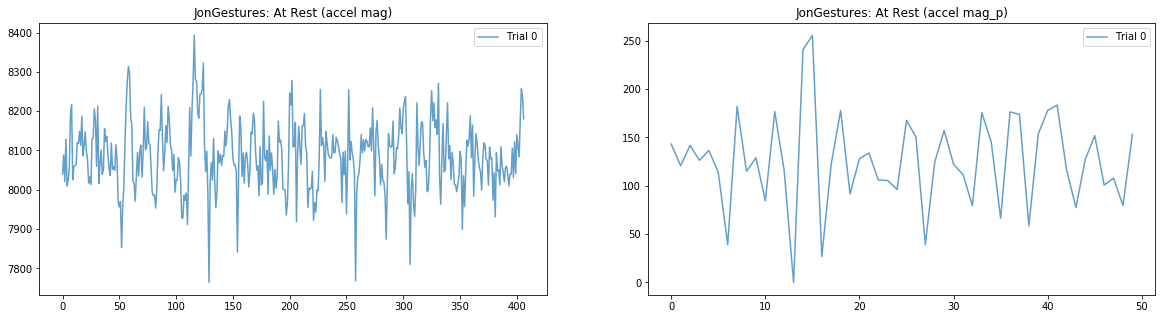

In [6]:
# Now let's plot both the raw and processed signal of a random gesture 
# pulled from a random trial. This helps us explore how our preprocessing
# is working
rand_gesture_name = selected_gesture_set.get_random_gesture_name()
#rand_gesture_name = "Underhand Bowling"


# We'll make a 1x2 grid of plots, so pass 1,2 to subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 5)) #figsize is width, height
rand_trial = selected_gesture_set.get_random_trial_for_gesture(rand_gesture_name)
#rand_trial = selected_gesture_set.get_trials_for_gesture(rand_gesture_name)[2]

axes[0].plot(rand_trial.accel.mag, alpha=0.7, label="Trial {}".format(rand_trial.trial_num))
axes[0].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (accel mag)")
axes[0].legend()

axes[1].plot(rand_trial.accel.mag_p, alpha=0.7, label="Trial {}".format(rand_trial.trial_num))
axes[1].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (accel mag_p)")
axes[1].legend(); # include semi-colon to hide return output from legend(), <matplotlib.legend.Legend at 0x263de45dd30>

# Feature exploration

We are going to start this adventure, as we always should, by trying to better understand our signals and the features we plan to extract.

Our goal is to brainstorm and identify highly discriminable attributes of each gesture class that we may be able to leverage in our feature-based classifiers.

While our classifiers will work in high-dimensions, humans, at best can really only visualize and interpret at most 3-dimensions.

So, we're going to start by graphing our features along 1-dimension. Yes, 1-dimension! To make it easier to see patterns in our data, we will add in a bit of y-jitter, so the graphs below may appear 2-dimensional—but they are not. Ignore the y-axis for these 1D plots.

## Time domain

Let's explore some time domain features first. We've created a helper function called `plot_feature_1d`, which will plot a specified feature in a 1-dimensional graph.

Let's check it out!

### Feature: standard deviation of accel mag

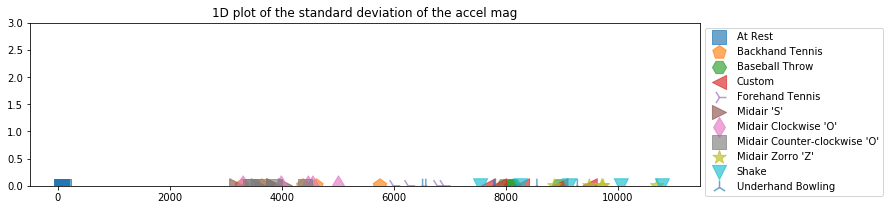

In [7]:
# Write a simple anonymous function that takes in an accel.trial and returns
# an extracted feature. In this case, the standard deviation of the magnitude
extract_feature_std_mag = lambda accel_trial: np.std(accel_trial.mag)

# We could also have done the following but it's slightly messier for our purposes
# def extract_feature_std_mag(accel_trial):
#    return np.std(accel_trial.mag)

# Plot the feature (but with no y-jitter)
graph_title = "1D plot of the standard deviation of the accel mag"
plot_feature_1d(selected_gesture_set, extract_feature_std_mag, 
                title = graph_title, use_random_y_jitter = False)

To make it easier to see the 1-dimensional spacing, by default, we add in a random y-jitter (which is a common graphing trick). But just remember, the y-values here are meaningless.

So, let's graph the same thing but with the random y jitter turned on.

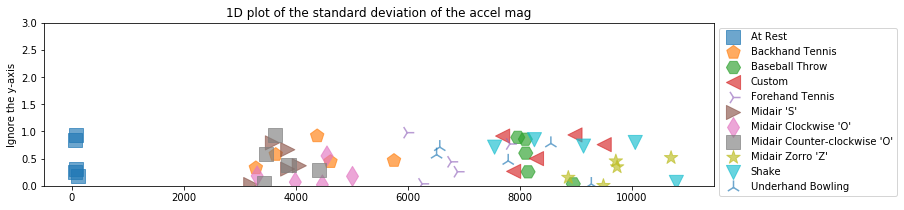

In [8]:
graph_title = "1D plot of the standard deviation of the accel mag"
plot_feature_1d(selected_gesture_set, extract_feature_std_mag, title = graph_title)

Even with just one feature and a 1D plot, we can begin to see some separation between gestures:
- Unsurprisingly, the *At Rest* gesture has the least amount of deviation
- And then there are ~2 or maybe 3 other groups: a middle group of *Clockwise 'O'*, *Counter-clockwise 'O'*, *Backhand Tennis*, a less defined intermediate group of *Forehand Tennis* and *Underhand Bowling*, and a more extreme group of *Shake*, *Midair Zorro 'Z'*, and *Baseball Throw*
    

### Feature: maximum accel mag

How about the **maximum** of the accelerometer magnitude in each gesture trial? Is there discriminable information there?

Let's check it out!

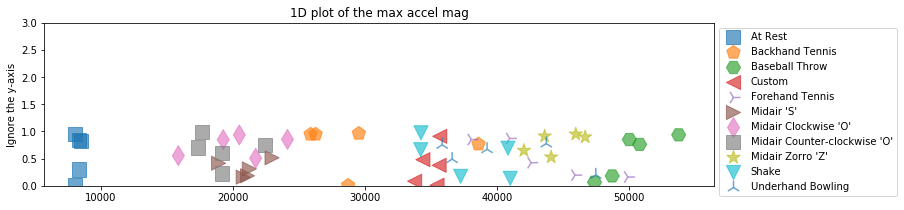

In [9]:
extract_feature_max_mag = lambda accel_trial: np.max(accel_trial.mag)
plot_feature_1d(selected_gesture_set, extract_feature_max_mag, 
                title = "1D plot of the max accel mag")

What do you observe? Again, this feature seems useful—at least for discriminating some gestures like *At Rest* and *Baseball Throw*. As before, there are also clear clusters that are emerging.

### Brainstorm and plot your own time domain features

Below, brainstorm and plot your own time domain features. We've provided an initial list of features to try but dig into the signals, think about what makes each gesture class unique, and try to extract and leverage those unique aspects as features. 

You could extract (many of) these features either from the raw accelerometer signal (*e.g.,* `x`, `y`, `z`, and `mag`) or a preprocessed version.

- Signal length
- Descriptive statistics of each axis (x, y, z) + magnitude, including mean, median, standard deviation
- Peak counting (raw number of peaks, number of peaks over certain threshold)
- Horizontal distance between peaks, avg vertical distance between peaks
- Number of zero crossings
- Other things! Read papers, brainstorm, visualize!

Once you've exhausted our list and your own mind, consult the web. Use [Google Scholar](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C48&q=gesture+recognition+accelerometer&btnG=), for example, to find gesture recognition papers: what features did they use?

#### Signal Length

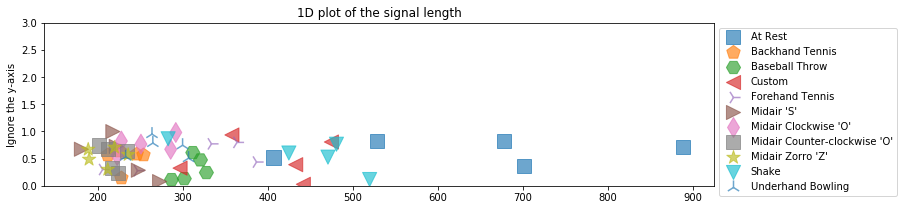

In [10]:
# We'll start with another one here: signal length but add more!

extract_feature_signal_length = lambda accel_trial: len(accel_trial.x)
plot_feature_1d(selected_gesture_set, extract_feature_signal_length, 
                title = "1D plot of the signal length")

#### Mean Signal Value

From my observation, mean magnitude seems to bucket the gestures best,

While mean z is worst.

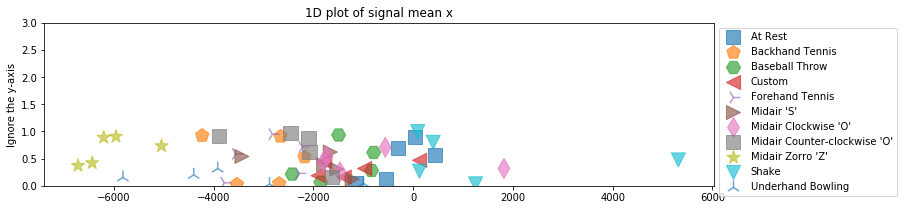

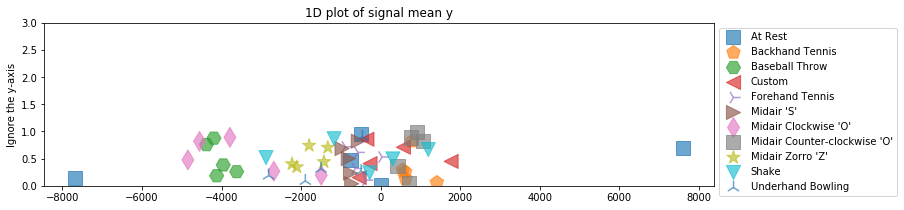

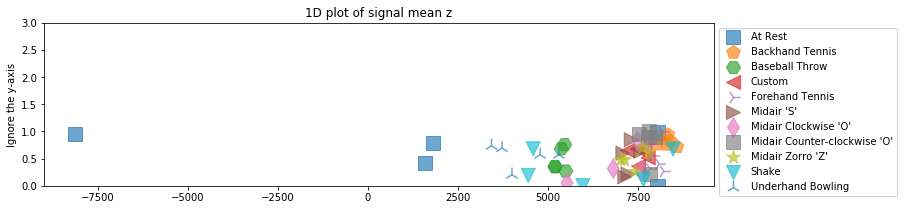

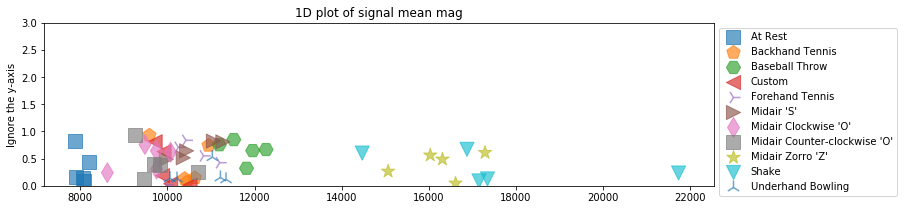

In [11]:
# Look at mean value of different signals.

extract_feature_mean_x = lambda accel_trial: np.mean(accel_trial.x)
extract_feature_mean_y = lambda accel_trial: np.mean(accel_trial.y)
extract_feature_mean_z = lambda accel_trial: np.mean(accel_trial.z)
extract_feature_mean_mag = lambda accel_trial: np.mean(accel_trial.mag)

plot_feature_1d(selected_gesture_set, extract_feature_mean_x, 
                title = "1D plot of signal mean x")
plot_feature_1d(selected_gesture_set, extract_feature_mean_y, 
                title = "1D plot of signal mean y")
plot_feature_1d(selected_gesture_set, extract_feature_mean_z, 
                title = "1D plot of signal mean z")
plot_feature_1d(selected_gesture_set, extract_feature_mean_mag, 
                title = "1D plot of signal mean mag")

#### Median Signal Value

None of these look particularly useful.

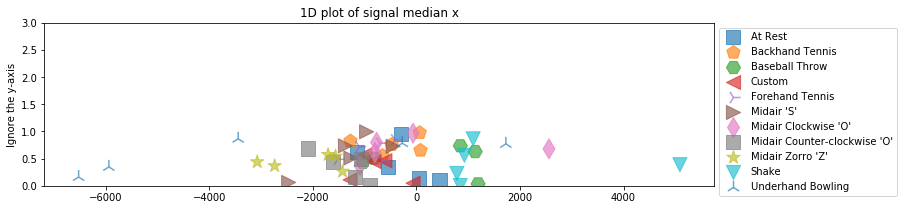

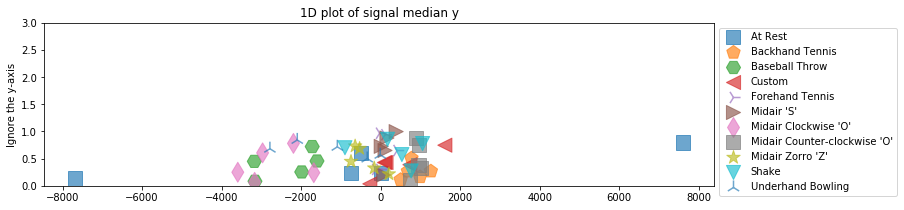

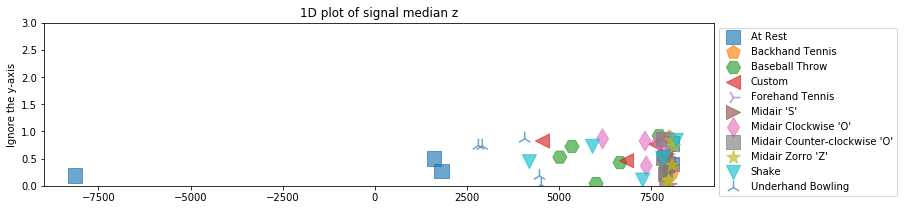

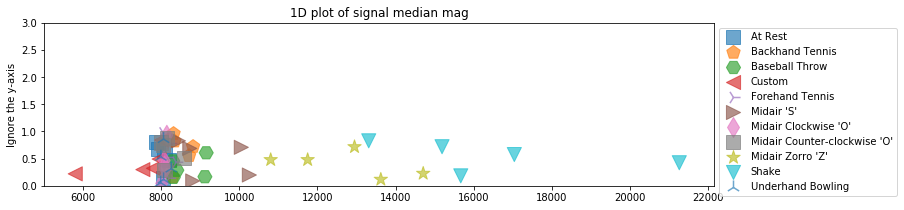

In [12]:
# Look at median value of different signals.

extract_feature_median_x = lambda accel_trial: np.median(accel_trial.x)
extract_feature_median_y = lambda accel_trial: np.median(accel_trial.y)
extract_feature_median_z = lambda accel_trial: np.median(accel_trial.z)
extract_feature_median_mag = lambda accel_trial: np.median(accel_trial.mag)

plot_feature_1d(selected_gesture_set, extract_feature_median_x, 
                title = "1D plot of signal median x")
plot_feature_1d(selected_gesture_set, extract_feature_median_y, 
                title = "1D plot of signal median y")
plot_feature_1d(selected_gesture_set, extract_feature_median_z, 
                title = "1D plot of signal median z")
plot_feature_1d(selected_gesture_set, extract_feature_median_mag, 
                title = "1D plot of signal median mag")

#### Signal Standard Deviation

From these graphs, the stdev of the y axis data looks useful,

And possibly the z axis data for some gestures.

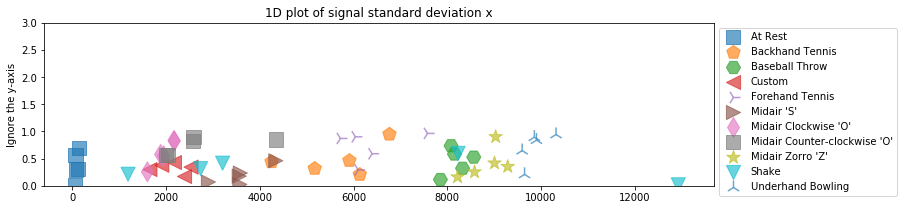

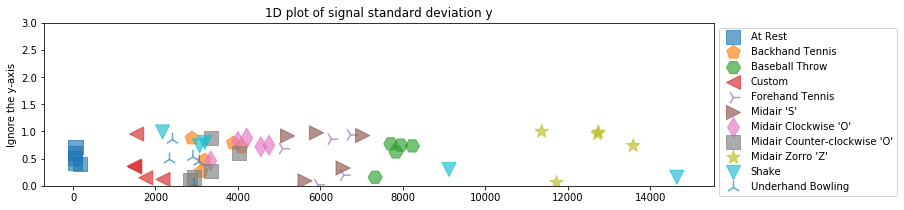

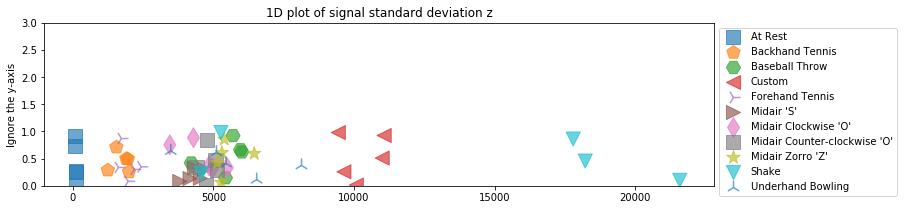

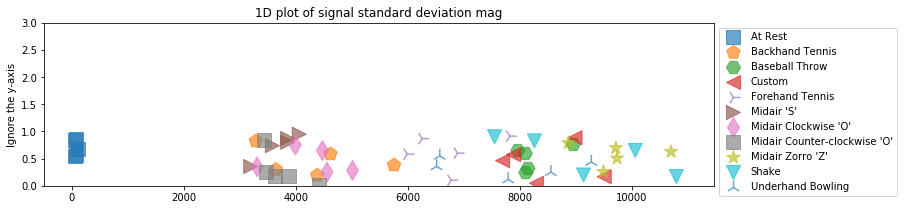

In [13]:
# Look at standard deviation value of different signals.

extract_feature_stdev_x = lambda accel_trial: np.std(accel_trial.x)
extract_feature_stdev_y = lambda accel_trial: np.std(accel_trial.y)
extract_feature_stdev_z = lambda accel_trial: np.std(accel_trial.z)
extract_feature_stdev_mag = lambda accel_trial: np.std(accel_trial.mag)

plot_feature_1d(selected_gesture_set, extract_feature_stdev_x, 
                title = "1D plot of signal standard deviation x")
plot_feature_1d(selected_gesture_set, extract_feature_stdev_y, 
                title = "1D plot of signal standard deviation y")
plot_feature_1d(selected_gesture_set, extract_feature_stdev_z, 
                title = "1D plot of signal standard deviation z")
plot_feature_1d(selected_gesture_set, extract_feature_stdev_mag, 
                title = "1D plot of signal standard deviation mag")

#### Raw number of peaks

This data appears accurate: I would expect "at rest" to be highest as it oscillates randomly around 0.

Will definitely need thresholding to separate!

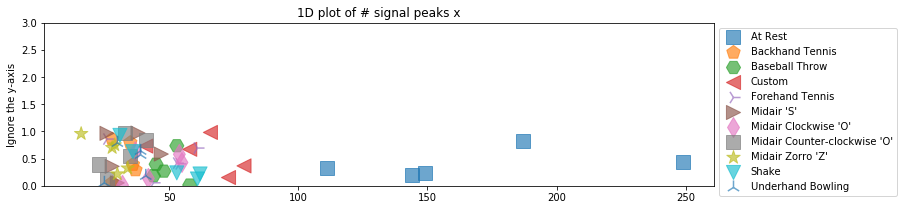

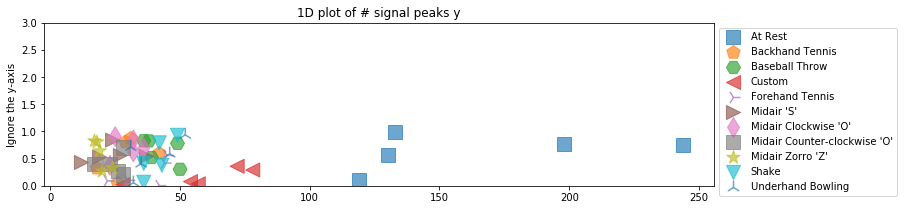

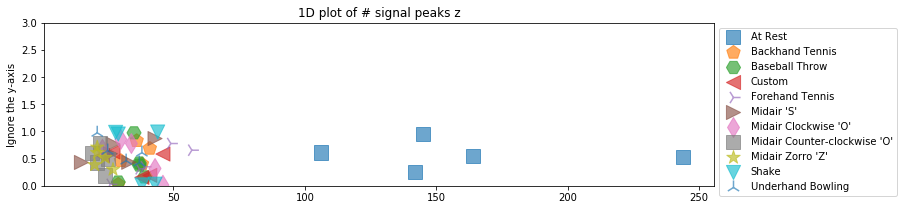

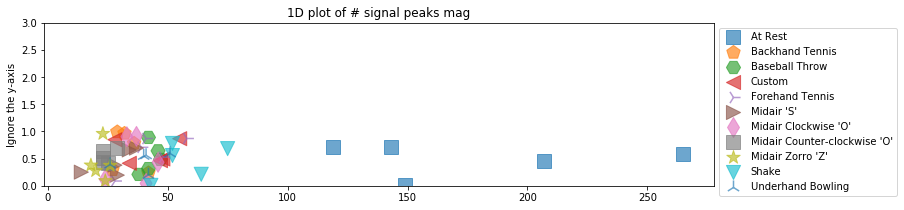

In [14]:
# Look at raw number of signal peaks (peak counting).

extract_feature_peaks_x = lambda accel_trial: len(signal.find_peaks(accel_trial.x)[0])
extract_feature_peaks_y = lambda accel_trial: len(signal.find_peaks(accel_trial.y)[0])
extract_feature_peaks_z = lambda accel_trial: len(signal.find_peaks(accel_trial.z)[0])
extract_feature_peaks_mag = lambda accel_trial: len(signal.find_peaks(accel_trial.mag)[0])

# for gesture_name in selected_gesture_set.get_gesture_names_sorted():
#     #print(gesture_name)
#     trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
#     for trial in trials:
#         # x = list(extract_feature_func(trial.accel) for trial in trials)
#         #print(len(trial.accel.x))
#         print(signal.find_peaks(trial.accel.mag)[0])

plot_feature_1d(selected_gesture_set, extract_feature_peaks_x, 
                title = "1D plot of # signal peaks x")
plot_feature_1d(selected_gesture_set, extract_feature_peaks_y, 
                title = "1D plot of # signal peaks y")
plot_feature_1d(selected_gesture_set, extract_feature_peaks_z, 
                title = "1D plot of # signal peaks z")
plot_feature_1d(selected_gesture_set, extract_feature_peaks_mag, 
                title = "1D plot of # signal peaks mag")

#### Num peaks over threshold

Using the pre-processed signal is especially important here for meaninful results.

[ 3  5  8 10 16 19 21 30 32 37 41 46 48]


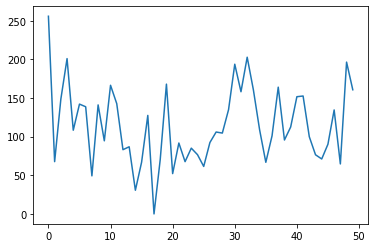

[ 3 10 13 15 17 20 23 27 30 33 37 42 45]


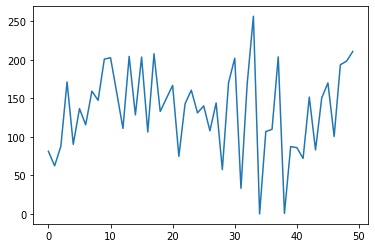

[ 3  6 11 15 18 21 23 26 28 30 32 36 39 41 46 48]


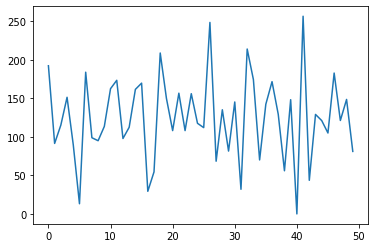

[ 2  4  6 13 17 25 31 34 38 42 46 48]


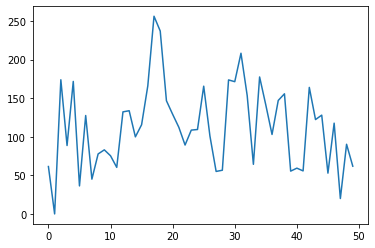

[ 1  3  5 12 16 40 48]


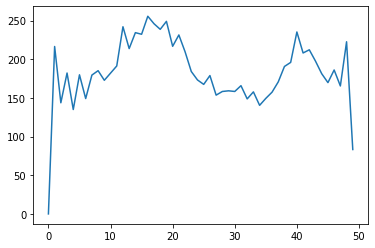

[ 9 25 29]


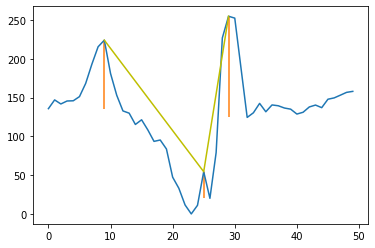

[10 27]


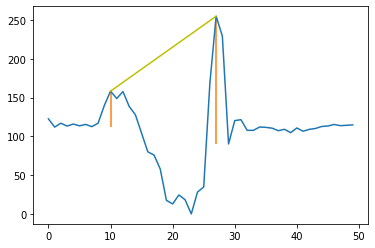

[ 9 25 29 31]


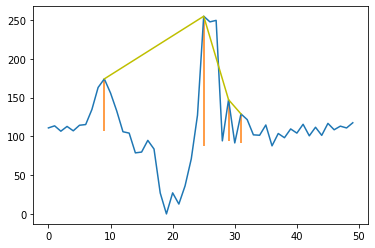

[ 4 22 25]


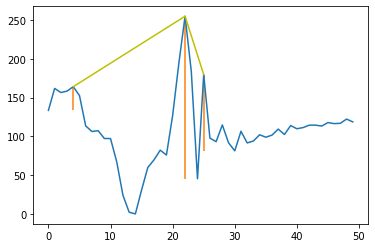

[11 19 30]


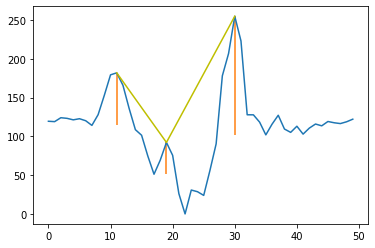

[15 31 36]


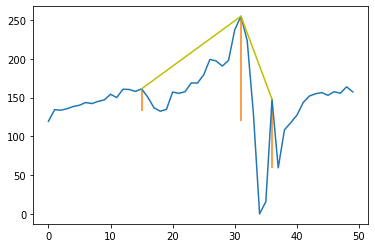

[36 40]


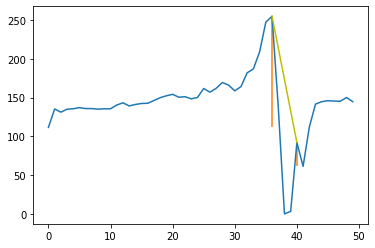

[33]


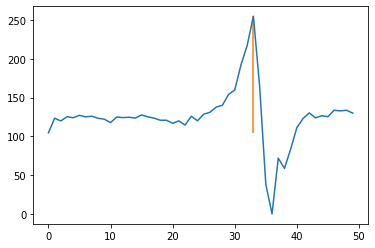

[36]


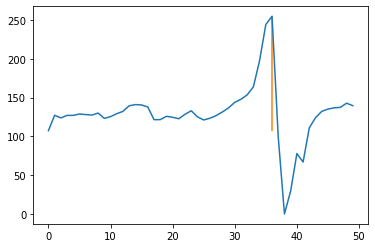

[13 35]


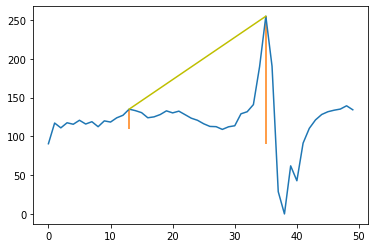

[12 21 30 32 39]


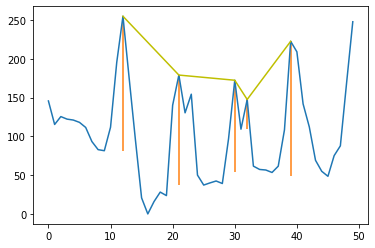

[ 4  8 16 18 20 23 27 34 38]


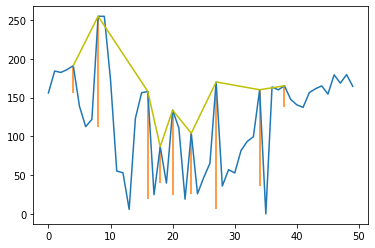

[ 8 12 14 19 27 32 39]


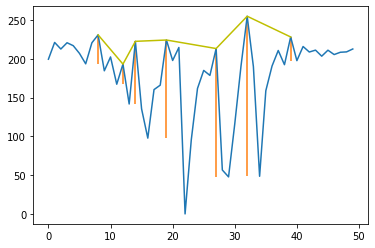

[12 18 20 26 28 32 34 36 44 46]


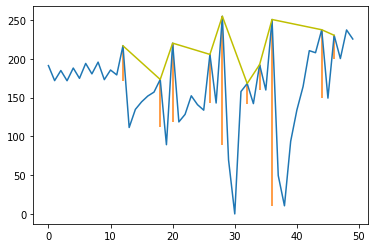

[14 19 21 27 33]


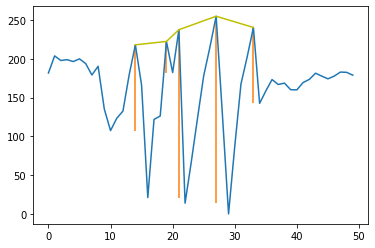

[23]


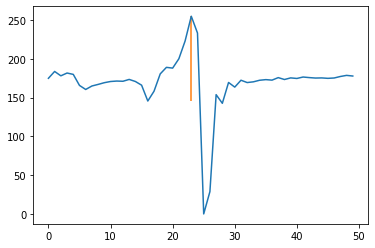

[34 40]


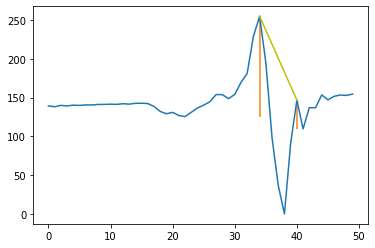

[18]


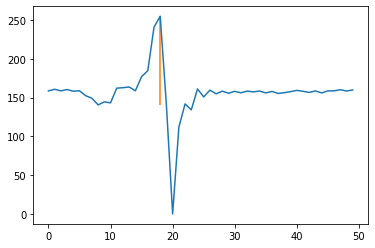

[16]


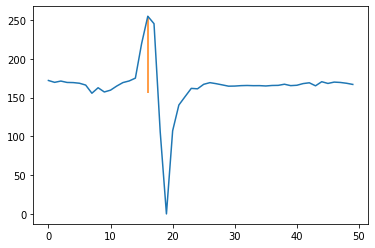

[28 35]


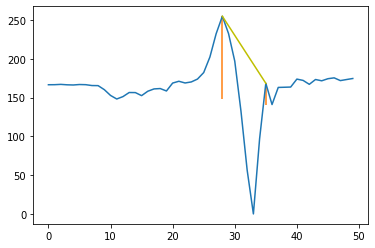

[18 33]


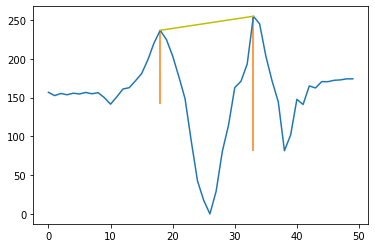

[22 42]


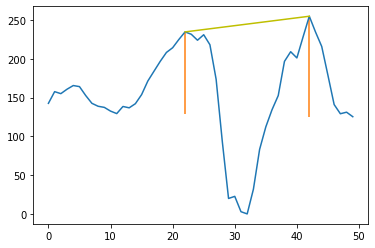

[22 34]


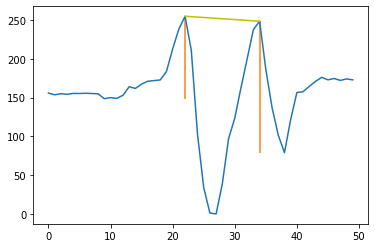

[18 34]


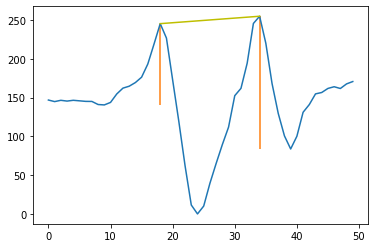

[20 33]


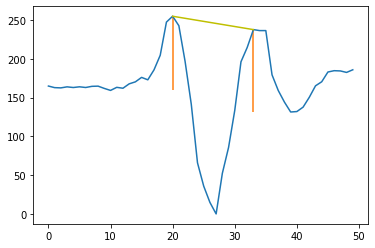

[20 32]


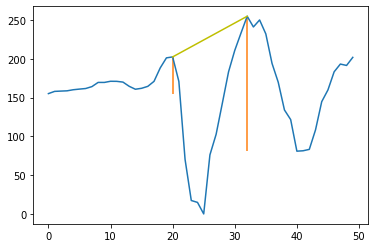

[ 9 21]


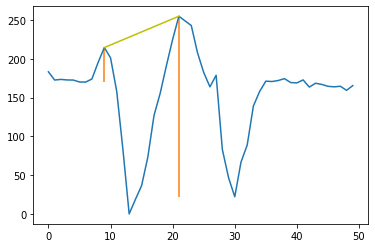

[16 36]


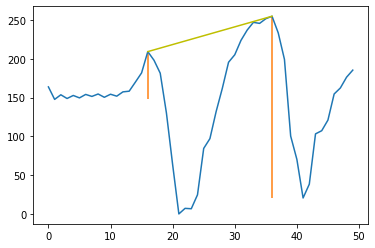

[14 33]


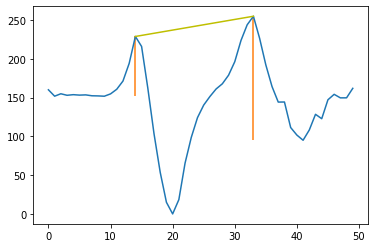

[14 32]


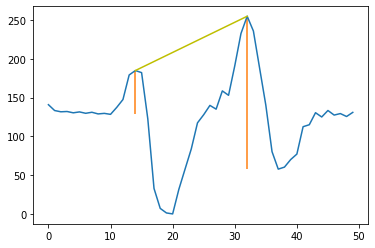

[20 23 32 40]


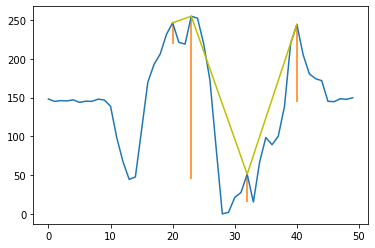

[18 31 40]


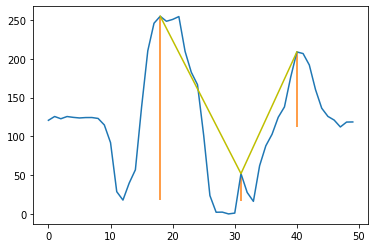

[21 41]


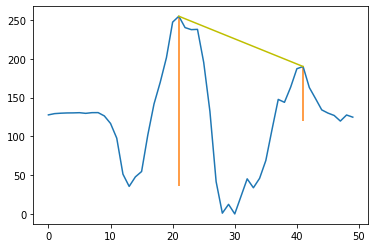

[19 40]


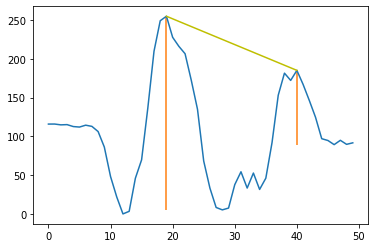

[20 42]


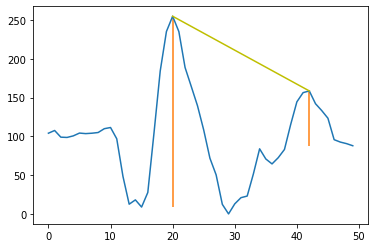

[28 40]


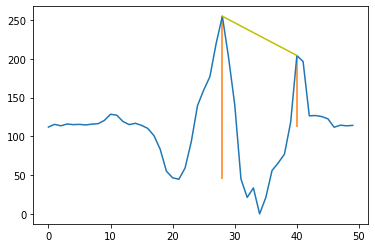

[24 35]


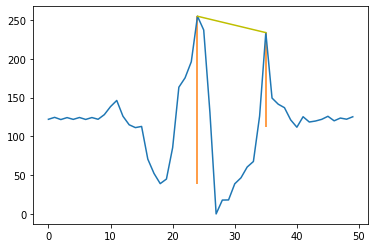

[28 39]


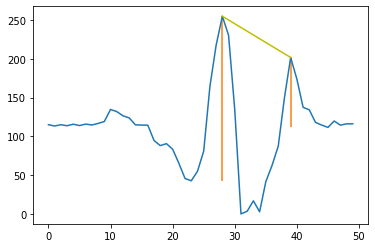

[14 28 40]


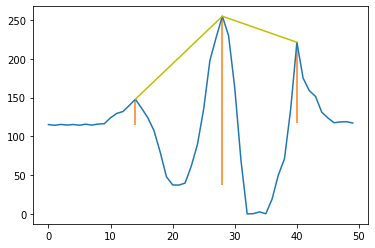

[27 38]


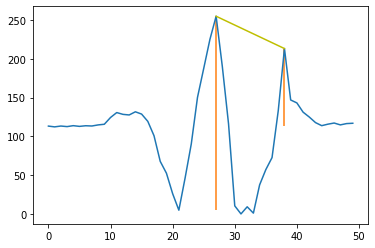

[ 4  6  8 11 13 26 31 34 38 42 46]


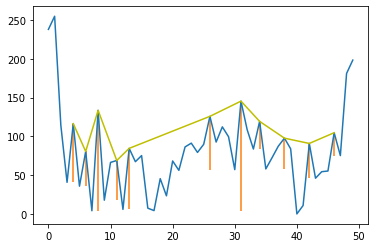

[ 1  3  8 10 13 15 17 19 21 23 25 27 29 31 33 35 37 40 42 44 46]


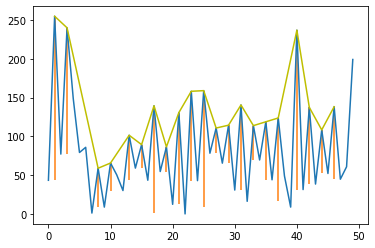

[ 3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 40 42 44 46 48]


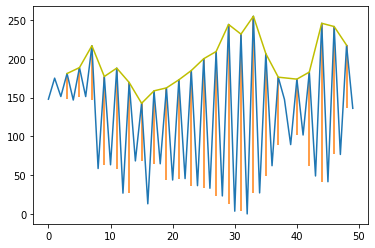

[11 13 15 17 20 22 24 26 28 31 33 35 38 40 42 45 47]


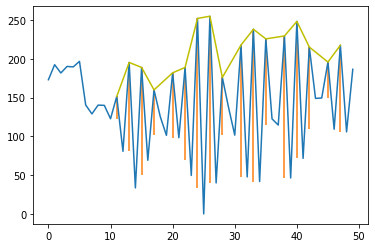

[ 2  4  6 10 12 15 18 20 26 29 32 34 37 40 43 46]


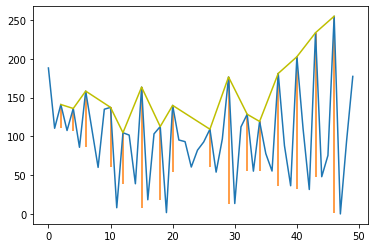

[25]


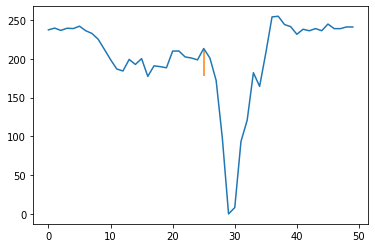

[20 31]


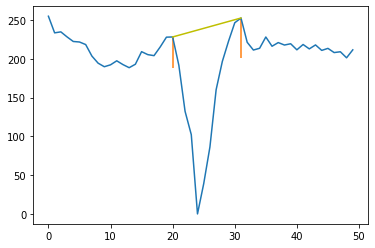

[26 39]


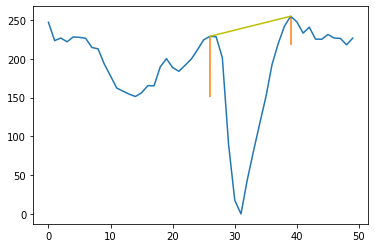

[25 37]


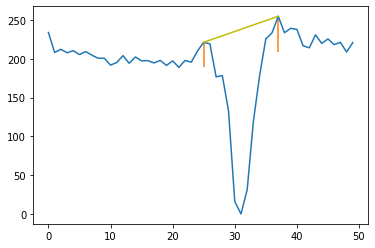

[17 26 29]


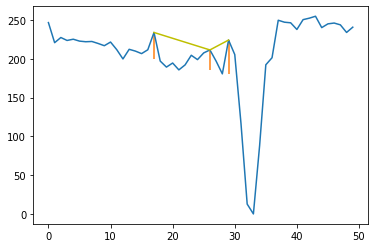

In [15]:
# First, try to find a reasonable value using prominence

#prominence = 1
peak_prominence = 25

for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    #print(gesture_name)
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    for trial in trials:        
        peaks, properties = signal.find_peaks(trial.accel.y_p, prominence=peak_prominence)
        print(peaks)
        plt.plot(trial.accel.y_p)
        if (gesture_name != "At Rest"):
            plt.plot(peaks, trial.accel.y_p[peaks], "y")
            plt.vlines(x=peaks, ymin=trial.accel.y_p[peaks] - properties["prominences"],
                       ymax = trial.accel.y_p[peaks], color = "C1")
#             plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
#                        xmax=properties["right_ips"], color = "C1")
        plt.show()

In [16]:
# Next, try to find useful values by enforcing a min distance between peaks

# Commenting this out for now as it doesn't look useful.

# for gesture_name in selected_gesture_set.get_gesture_names_sorted():
#     #print(gesture_name)
#     trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
#     for trial in trials:        
#         peaks, _ = signal.find_peaks(trial.accel.y_p, distance=10)
#         print(peaks)
#         plt.plot(trial.accel.y_p)
#         if (gesture_name != "At Rest"):
#             plt.plot(peaks, trial.accel.y_p[peaks], "y")
#         plt.show()

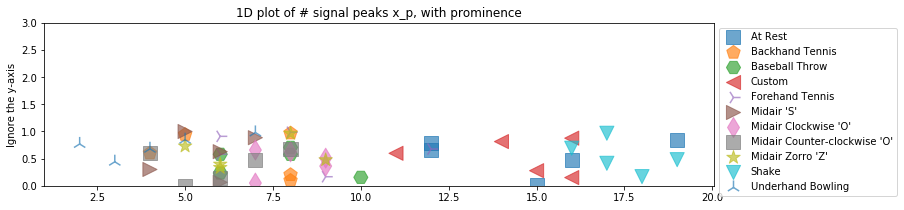

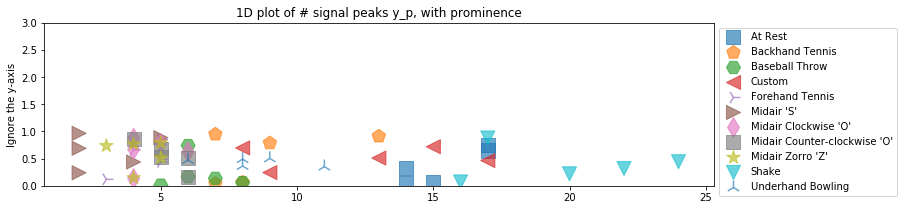

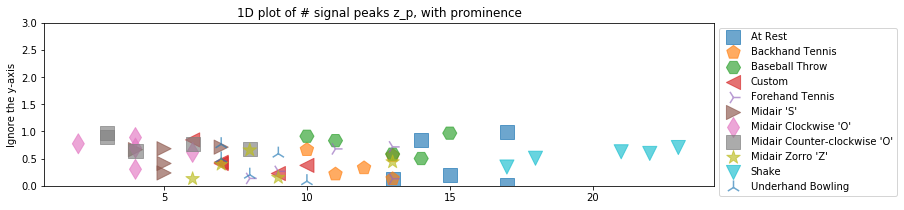

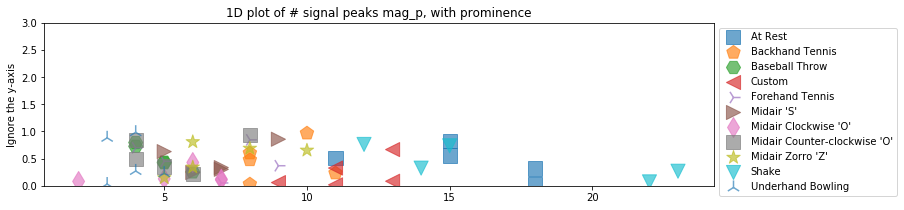

In [17]:
# Look at num peaks over threshold (peak counting).

# Despite trying different sampling and prominence values, this doesn't look useful.

peak_prominence = 4
#peak_prominence = 14

for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    #print(gesture_name)
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    for trial in trials:
        # x = list(extract_feature_func(trial.accel) for trial in trials)
        #print(len(trial.accel.x))
        #print(len(signal.find_peaks(trial.accel.x_p, prominence=peak_prominence)[0]))
        pass

extract_feature_peaks_above_prom_x_p = lambda accel_trial: len(signal.find_peaks(accel_trial.x_p, prominence=peak_prominence)[0])
extract_feature_peaks_above_prom_y_p = lambda accel_trial: len(signal.find_peaks(accel_trial.y_p, prominence=peak_prominence)[0])
extract_feature_peaks_above_prom_z_p = lambda accel_trial: len(signal.find_peaks(accel_trial.z_p, prominence=peak_prominence)[0])
extract_feature_peaks_above_prom_mag_p = lambda accel_trial: len(signal.find_peaks(accel_trial.mag_p, prominence=peak_prominence)[0])

plot_feature_1d(selected_gesture_set, extract_feature_peaks_above_prom_x_p, 
                title = "1D plot of # signal peaks x_p, with prominence")
plot_feature_1d(selected_gesture_set, extract_feature_peaks_above_prom_y_p, 
                title = "1D plot of # signal peaks y_p, with prominence")
plot_feature_1d(selected_gesture_set, extract_feature_peaks_above_prom_z_p, 
                title = "1D plot of # signal peaks z_p, with prominence")
plot_feature_1d(selected_gesture_set, extract_feature_peaks_above_prom_mag_p, 
                title = "1D plot of # signal peaks mag_p, with prominence")

#### Avg horiz dist between peaks

Best results found: z_p, resampling to 50 samples, with prominence 5

In [18]:
# First attempt:
resampling_values = [30, 50, 100]
prominence_values = [5, 10, 20]

# Second attempt:
# resampling_values = [40, 50, 60]
# prominence_values = [3, 5, 7]

peak_prominence = 5

# Define Lambda Functions
extract_feature_peaks_avg_horiz_dist_x_p = lambda accel_trial: np.average(np.diff(signal.find_peaks(accel_trial.x_p, prominence=peak_prominence)[0]))
extract_feature_peaks_avg_horiz_dist_y_p = lambda accel_trial: np.average(np.diff(signal.find_peaks(accel_trial.y_p, prominence=peak_prominence)[0]))
extract_feature_peaks_avg_horiz_dist_z_p = lambda accel_trial: np.average(np.diff(signal.find_peaks(accel_trial.z_p, prominence=peak_prominence)[0]))
extract_feature_peaks_avg_horiz_dist_mag_p = lambda accel_trial: np.average(np.diff(signal.find_peaks(accel_trial.mag_p, prominence=peak_prominence)[0]))

# For-loop for finding best hyperparameters
# for sampling_freq in resampling_values:
#     for prominence_val in prominence_values:
#         print("Samples: ", sampling_freq, " | Prominence: ", prominence_val)
#         # Preprocess data with this sampling frequency
#         for gesture_set in map_gesture_sets.values():
#             for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
#                 for trial in trials:
#                     preprocess_trial(trial, sampling_freq=sampling_freq)
#         # Plot graphs for this frequency/prominence combination
#         plot_feature_1d(selected_gesture_set, extract_feature_peaks_avg_horiz_dist_x_p, 
#                 title = ("1D plot of horiz dist between peaks x_p, Samples: ", sampling_freq, ", Prominence: ", prominence_val))
#         plot_feature_1d(selected_gesture_set, extract_feature_peaks_avg_horiz_dist_y_p, 
#                 title = ("1D plot of horiz dist between peaks y_p, Samples: ", sampling_freq, ", Prominence: ", prominence_val))
#         plot_feature_1d(selected_gesture_set, extract_feature_peaks_avg_horiz_dist_z_p, 
#                 title = ("1D plot of horiz dist between peaks z_p, Samples: ", sampling_freq, ", Prominence: ", prominence_val))
#         plot_feature_1d(selected_gesture_set, extract_feature_peaks_avg_horiz_dist_mag_p, 
#                 title = ("1D plot of horiz dist between peaks mag_p, Samples: ", sampling_freq, ", Prominence: ", prominence_val))

#### Avg vertical distance between peaks

Best results found: z_p, resampling: 50, prominence: 25

At Rest
Peak Values:
[200.97430282 142.09165668 141.05375501 166.45681493 127.46973271
 167.9403594   91.75410983 193.7165747  202.7773495  164.01811592
 152.57894268 134.53753136 196.44509849]
Vert distance between peaks:
[ 58.88264614   1.03790167  25.40305992  38.98708221  40.47062669
  76.18624957 101.96246487   9.06077479  38.75923358  11.43917324
  18.04141132  61.90756714]
Avg vert distance btw peaks for whole trial:
40.178182594544346


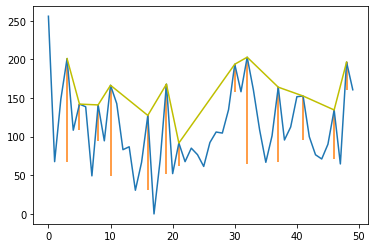

At Rest
Peak Values:
[171.20671425 202.56802211 204.24989143 203.34754929 207.64292042
 166.64918245 160.47983493 143.86843783 201.89386221 256.34366487
 203.62683631 151.50670698 169.79444198]
Vert distance between peaks:
[31.36130786  1.68186932  0.90234214  4.29537112 40.99373797  6.16934752
 16.61139709 58.02542438 54.44980265 52.71682855 52.12012934 18.287735  ]
Avg vert distance btw peaks for whole trial:
28.134607745983335


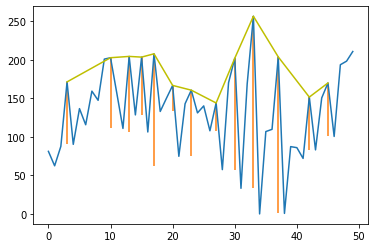

At Rest
Peak Values:
[151.34562463 183.89545922 173.3800593  169.68654235 208.80133992
 156.66157754 156.01314419 248.47957643 135.14342028 145.25383925
 213.96821778 171.61568293 148.22333995 256.50891847 182.79179332
 148.56500045]
Vert distance between peaks:
[ 32.54983459  10.51539992   3.69351694  39.11479757  52.13976239
   0.64843334  92.46643224 113.33615615  10.11041897  68.71437854
  42.35253486  23.39234298 108.28557851  73.71712514  34.22679287]
Avg vert distance btw peaks for whole trial:
47.017567000076134


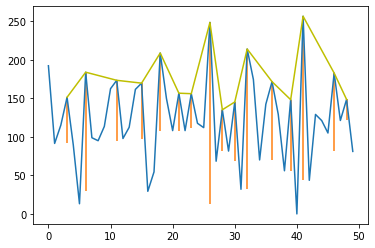

At Rest
Peak Values:
[173.76577889 171.61871983 127.46065837 133.66492601 256.04688832
 165.45425642 208.1340195  177.38154505 155.57772254 163.86790784
 117.55508154  90.19718207]
Vert distance between peaks:
[  2.14705906  44.15806146   6.20426764 122.38196232  90.5926319
  42.67976308  30.75247445  21.80382251   8.29018531  46.31282631
  27.35789947]
Avg vert distance btw peaks for whole trial:
40.24372304564497


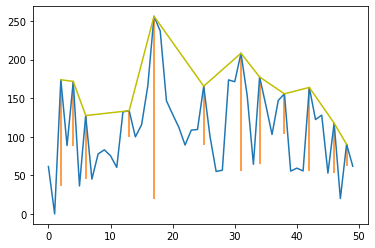

At Rest
Peak Values:
[216.39312503 182.11767789 179.80207701 241.92782378 255.50473429
 235.171352   222.52255782]
Vert distance between peaks:
[34.27544714  2.31560088 62.12574678 13.5769105  20.33338228 12.64879418]
Avg vert distance btw peaks for whole trial:
24.212646960954075


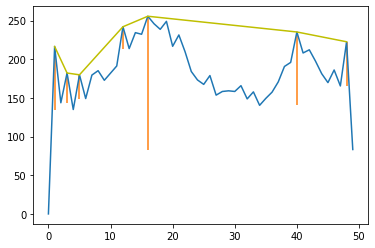

Backhand Tennis
Peak Values:
[224.1251534   54.45879408 255.00563218]
Vert distance between peaks:
[169.66635932 200.5468381 ]
Avg vert distance btw peaks for whole trial:
185.10659871343063


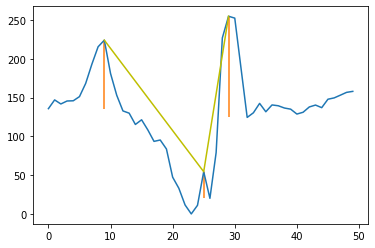

Backhand Tennis
Peak Values:
[158.35119579 255.00735347]
Vert distance between peaks:
[96.65615767]
Avg vert distance btw peaks for whole trial:
96.65615767450677


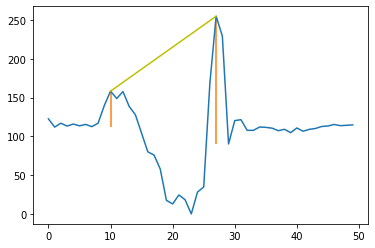

Backhand Tennis
Peak Values:
[174.19274991 255.01200649 147.34301892 129.01069772]
Vert distance between peaks:
[ 80.81925658 107.66898757  18.3323212 ]
Avg vert distance btw peaks for whole trial:
68.94018844908717


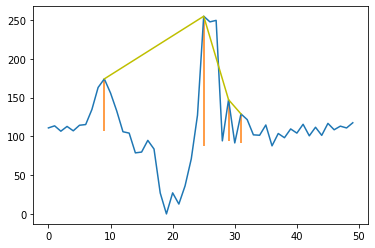

Backhand Tennis
Peak Values:
[164.13337235 255.01046518 179.78874785]
Vert distance between peaks:
[90.87709283 75.22171733]
Avg vert distance btw peaks for whole trial:
83.04940507799981


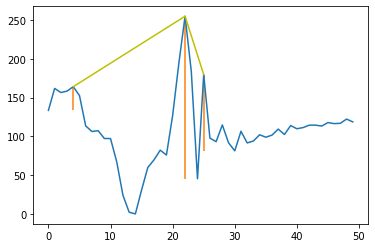

Backhand Tennis
Peak Values:
[181.98736533  92.21536783 255.01116561]
Vert distance between peaks:
[ 89.7719975  162.79579778]
Avg vert distance btw peaks for whole trial:
126.28389763985355


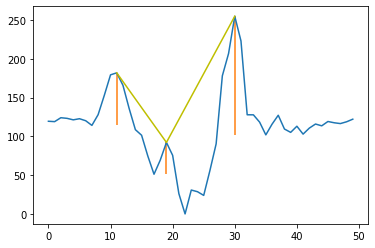

Baseball Throw
Peak Values:
[161.35048062 255.00391072 147.80486576]
Vert distance between peaks:
[ 93.6534301  107.19904496]
Avg vert distance btw peaks for whole trial:
100.42623753033017


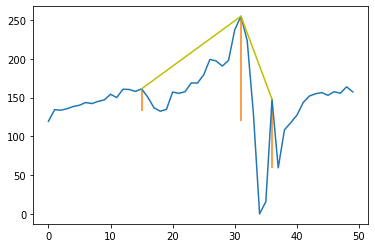

Baseball Throw
Peak Values:
[255.00083693  92.15981553]
Vert distance between peaks:
[162.8410214]
Avg vert distance btw peaks for whole trial:
162.84102140280888


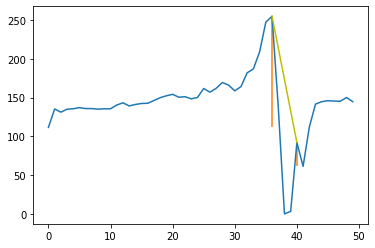

Baseball Throw
Peak Values:
[255.00016864]
Vert distance between peaks:
[]
Avg vert distance btw peaks for whole trial:
nan


C:\Users\dusti\anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\dusti\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


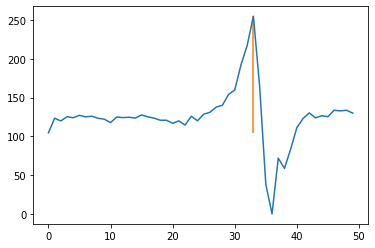

Baseball Throw
Peak Values:
[255.00395689]
Vert distance between peaks:
[]
Avg vert distance btw peaks for whole trial:
nan


C:\Users\dusti\anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\dusti\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


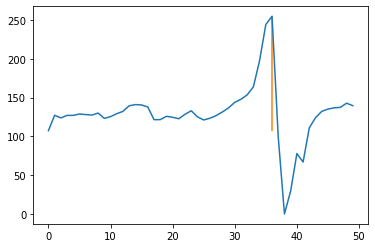

Baseball Throw
Peak Values:
[135.14013726 255.00160623]
Vert distance between peaks:
[119.86146897]
Avg vert distance btw peaks for whole trial:
119.8614689689391


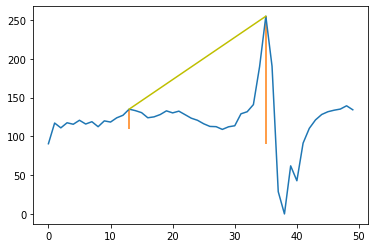

Custom
Peak Values:
[255.00283102 179.12410559 172.44173258 147.63953275 222.65084063]
Vert distance between peaks:
[75.87872543  6.68237301 24.80219983 75.01130788]
Avg vert distance btw peaks for whole trial:
45.593651538380286


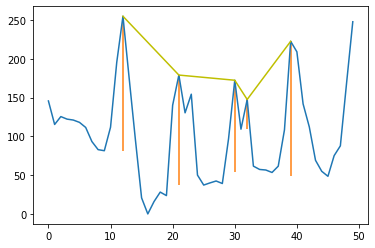

Custom
Peak Values:
[191.26380597 255.0249181  158.0141845   86.86433311 133.89848308
 104.01393142 170.23729015 160.19995978 165.26812827]
Vert distance between peaks:
[63.76111213 97.0107336  71.14985139 47.03414997 29.88455166 66.22335873
 10.03733037  5.06816849]
Avg vert distance btw peaks for whole trial:
48.771157042487886


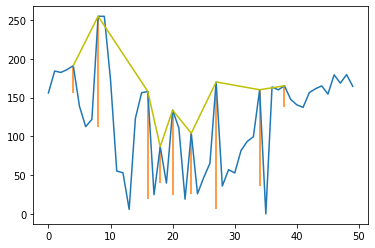

Custom
Peak Values:
[230.9806464  193.27290397 222.64958361 224.3470448  213.35314033
 255.02291229 228.28582034]
Vert distance between peaks:
[37.70774242 29.37667964  1.69746119 10.99390448 41.66977197 26.73709195]
Avg vert distance btw peaks for whole trial:
24.69710860793687


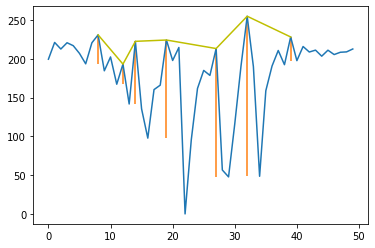

Custom
Peak Values:
[216.90683799 173.46469496 220.3245294  205.78239293 255.02106552
 168.1908043  192.64774291 250.81629852 237.59560126 230.44956993]
Vert distance between peaks:
[43.44214303 46.85983444 14.54213647 49.2386726  86.83026122 24.45693861
 58.16855561 13.22069726  7.14603133]
Avg vert distance btw peaks for whole trial:
38.21169672870138


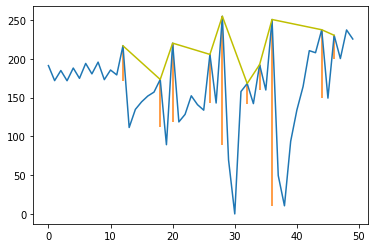

Custom
Peak Values:
[218.121259   222.52433093 237.58959789 255.00942651 240.56218545]
Vert distance between peaks:
[ 4.40307193 15.06526696 17.41982862 14.44724106]
Avg vert distance btw peaks for whole trial:
12.833852142909599


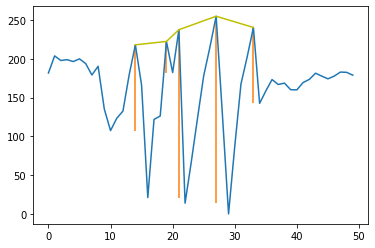

Forehand Tennis
Peak Values:
[255.00436269]
Vert distance between peaks:
[]
Avg vert distance btw peaks for whole trial:
nan


C:\Users\dusti\anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\dusti\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


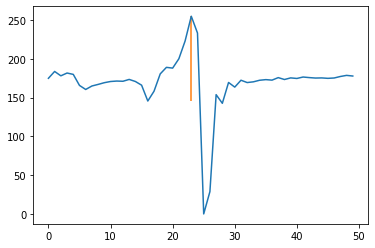

Forehand Tennis
Peak Values:
[255.00040204 146.83610257]
Vert distance between peaks:
[108.16429947]
Avg vert distance btw peaks for whole trial:
108.16429946814313


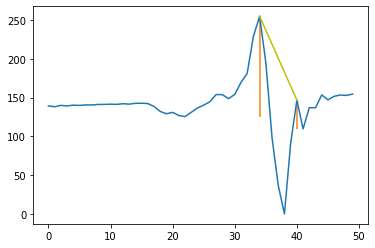

Forehand Tennis
Peak Values:
[255.00005205]
Vert distance between peaks:
[]
Avg vert distance btw peaks for whole trial:
nan


C:\Users\dusti\anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\dusti\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


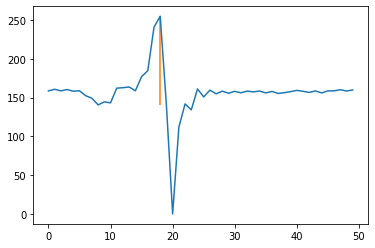

Forehand Tennis
Peak Values:
[255.00502189]
Vert distance between peaks:
[]
Avg vert distance btw peaks for whole trial:
nan


C:\Users\dusti\anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\dusti\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


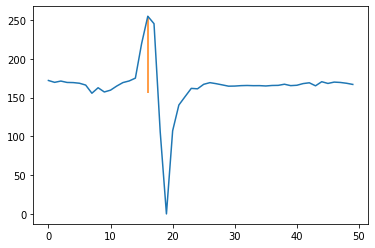

Forehand Tennis
Peak Values:
[255.00233064 168.51499969]
Vert distance between peaks:
[86.48733095]
Avg vert distance btw peaks for whole trial:
86.48733094825991


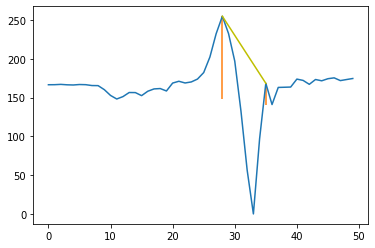

Midair 'S'
Peak Values:
[236.84333059 255.00487133]
Vert distance between peaks:
[18.16154073]
Avg vert distance btw peaks for whole trial:
18.161540732986538


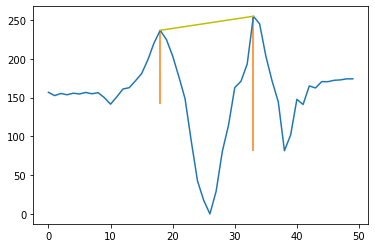

Midair 'S'
Peak Values:
[234.80002377 255.00638664]
Vert distance between peaks:
[20.20636286]
Avg vert distance btw peaks for whole trial:
20.2063628628473


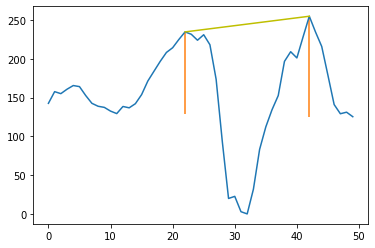

Midair 'S'
Peak Values:
[255.00666981 248.56017379]
Vert distance between peaks:
[6.44649602]
Avg vert distance btw peaks for whole trial:
6.446496021624114


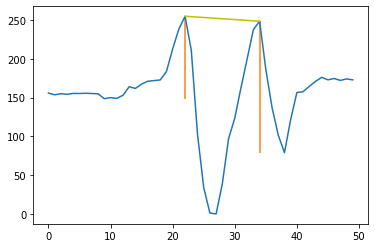

Midair 'S'
Peak Values:
[245.44903294 255.00068034]
Vert distance between peaks:
[9.5516474]
Avg vert distance btw peaks for whole trial:
9.551647395556472


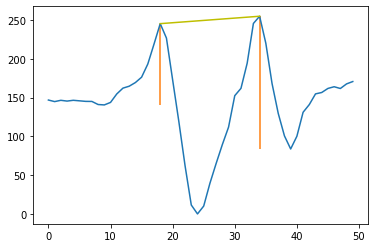

Midair 'S'
Peak Values:
[255.00687315 237.76251412]
Vert distance between peaks:
[17.24435904]
Avg vert distance btw peaks for whole trial:
17.24435903870446


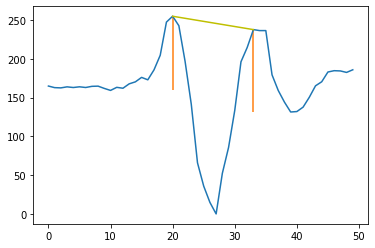

Midair Clockwise 'O'
Peak Values:
[202.53824609 255.00819152]
Vert distance between peaks:
[52.46994544]
Avg vert distance btw peaks for whole trial:
52.46994543547632


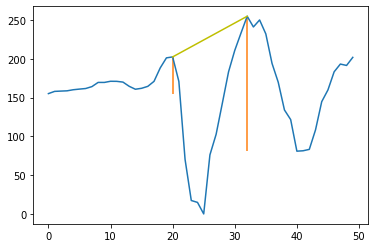

Midair Clockwise 'O'
Peak Values:
[214.58132723 255.01263303]
Vert distance between peaks:
[40.4313058]
Avg vert distance btw peaks for whole trial:
40.43130580185431


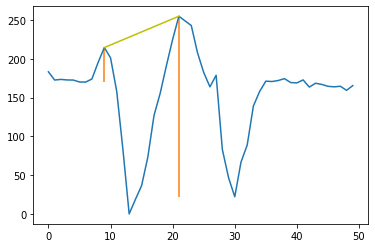

Midair Clockwise 'O'
Peak Values:
[209.3797978 255.0115139]
Vert distance between peaks:
[45.6317161]
Avg vert distance btw peaks for whole trial:
45.63171610069821


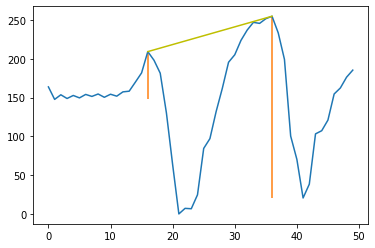

Midair Clockwise 'O'
Peak Values:
[228.91378715 255.00462204]
Vert distance between peaks:
[26.0908349]
Avg vert distance btw peaks for whole trial:
26.090834897797208


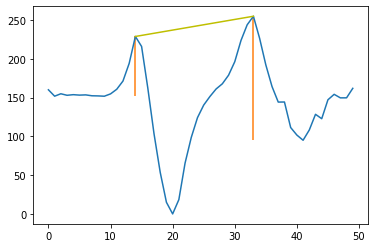

Midair Clockwise 'O'
Peak Values:
[184.95360624 255.00343823]
Vert distance between peaks:
[70.04983199]
Avg vert distance btw peaks for whole trial:
70.04983198919822


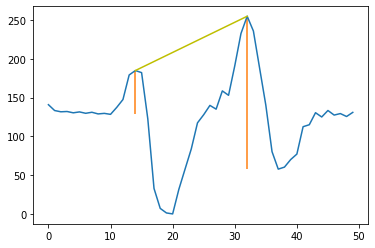

Midair Counter-clockwise 'O'
Peak Values:
[246.59392493 255.01026833  51.27801429 244.48367196]
Vert distance between peaks:
[  8.41634341 203.73225404 193.20565767]
Avg vert distance btw peaks for whole trial:
135.118085038912


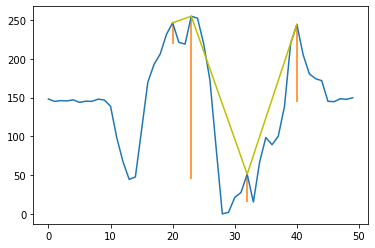

Midair Counter-clockwise 'O'
Peak Values:
[255.00596352  51.96899051 208.96042884]
Vert distance between peaks:
[203.03697301 156.99143833]
Avg vert distance btw peaks for whole trial:
180.0142056709696


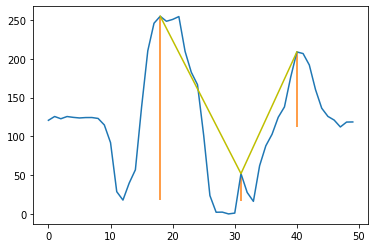

Midair Counter-clockwise 'O'
Peak Values:
[255.00576321 190.15094985]
Vert distance between peaks:
[64.85481336]
Avg vert distance btw peaks for whole trial:
64.85481335566462


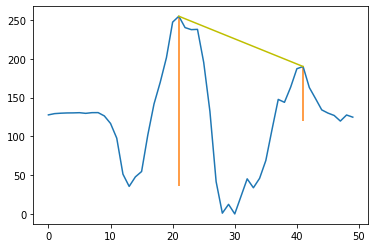

Midair Counter-clockwise 'O'
Peak Values:
[255.00292335 185.17322953]
Vert distance between peaks:
[69.82969382]
Avg vert distance btw peaks for whole trial:
69.82969381871047


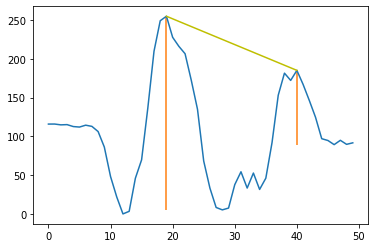

Midair Counter-clockwise 'O'
Peak Values:
[255.00869007 158.65051257]
Vert distance between peaks:
[96.3581775]
Avg vert distance btw peaks for whole trial:
96.35817750214463


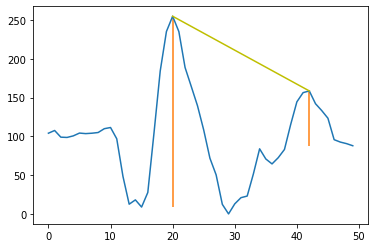

Midair Zorro 'Z'
Peak Values:
[255.00213828 204.37499804]
Vert distance between peaks:
[50.62714025]
Avg vert distance btw peaks for whole trial:
50.627140245022815


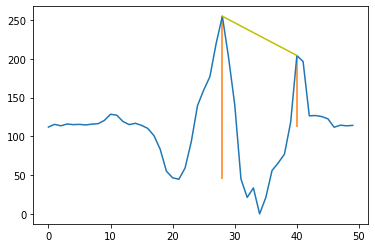

Midair Zorro 'Z'
Peak Values:
[255.00222232 233.89204475]
Vert distance between peaks:
[21.11017757]
Avg vert distance btw peaks for whole trial:
21.110177569548256


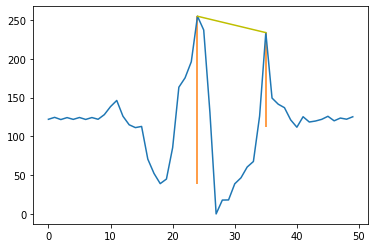

Midair Zorro 'Z'
Peak Values:
[255.0040091  201.79728872]
Vert distance between peaks:
[53.20672038]
Avg vert distance btw peaks for whole trial:
53.206720380076376


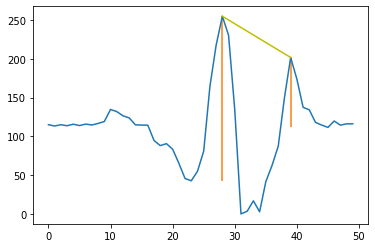

Midair Zorro 'Z'
Peak Values:
[147.978561   255.00205774 221.4482634 ]
Vert distance between peaks:
[107.02349674  33.55379434]
Avg vert distance btw peaks for whole trial:
70.28864553783245


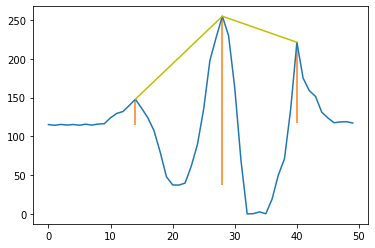

Midair Zorro 'Z'
Peak Values:
[255.00091537 213.3168403 ]
Vert distance between peaks:
[41.68407506]
Avg vert distance btw peaks for whole trial:
41.684075061786956


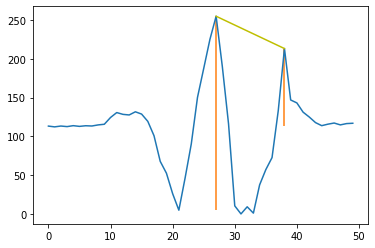

Shake
Peak Values:
[116.4664574   80.60782499 133.63100812  68.92889185  84.56677559
 125.88915188 145.5050869  119.38760297  97.72784223  90.92092442
 104.74222544]
Vert distance between peaks:
[35.85863241 53.02318313 64.70211627 15.63788374 41.32237629 19.61593502
 26.11748393 21.65976074  6.80691781 13.82130102]
Avg vert distance btw peaks for whole trial:
29.856559035985118


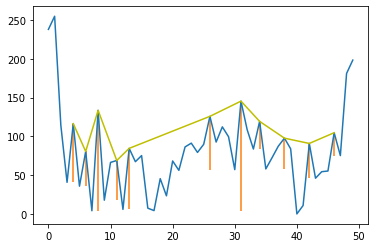

Shake
Peak Values:
[255.01435308 240.10686304  58.93619396  65.65965605 101.48085635
  89.38096088 139.4979594   86.52279138 130.71174465 158.20914339
 159.02862423 110.78198955 114.47556907 140.56015341 113.90078108
 118.86033997 123.77362572 237.04639225 137.4921719  108.39579954
 138.29900917]
Vert distance between peaks:
[ 14.90749004 181.17066909   6.7234621   35.8212003   12.09989547
  50.11699851  52.97516801  44.18895326  27.49739875   0.81948084
  48.24663469   3.69357952  26.08458434  26.65937234   4.95955889
   4.91328575 113.27276652  99.55422035  29.09637236  29.90320963]
Avg vert distance btw peaks for whole trial:
40.63521503828073


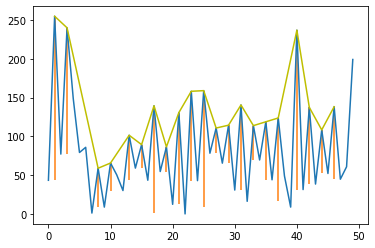

Shake
Peak Values:
[181.09898364 188.77943808 216.96711323 177.25797482 188.08700892
 169.56073284 142.69997097 158.76887466 162.57276805 173.00414389
 184.96592825 200.20004455 209.50746977 244.43042601 231.93871845
 255.00743075 206.80367656 176.41381277 173.854681   182.96515732
 245.93864877 241.7325704  217.66798503]
Vert distance between peaks:
[ 7.68045444 28.18767514 39.70913841 10.8290341  18.52627608 26.86076187
 16.06890369  3.80389339 10.43137584 11.96178435 15.23411631  9.30742522
 34.92295624 12.49170756 23.0687123  48.2037542  30.38986379  2.55913177
  9.11047632 62.97349144  4.20607836 24.06458537]
Avg vert distance btw peaks for whole trial:
20.4814361913251


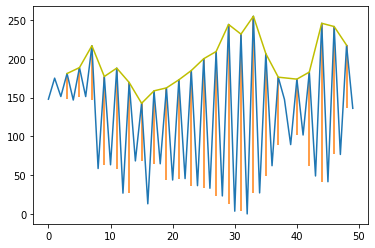

Shake
Peak Values:
[151.50903203 195.40408561 189.00618338 160.01422988 182.04755174
 188.96507487 252.21810143 255.01999249 176.02941705 217.78664369
 238.2344888  225.82504772 229.58510322 248.34262603 215.28277856
 195.89846343 217.61033   ]
Vert distance between peaks:
[43.89505358  6.39790223 28.9919535  22.03332186  6.91752313 63.25302656
  2.80189107 78.99057545 41.75722664 20.44784511 12.40944108  3.7600555
 18.75752281 33.05984747 19.38431513 21.71186657]
Avg vert distance btw peaks for whole trial:
26.53558548053512


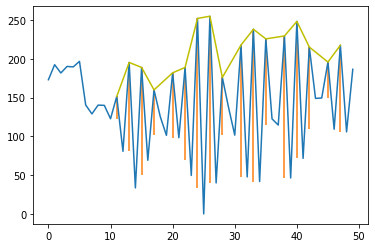

Shake
Peak Values:
[141.15895631 136.02741854 158.45028943 137.44282276 104.75449585
 163.59075197 112.69751447 140.00621311 109.26996192 176.65966522
 128.559901   119.28957671 181.2621572  202.76062126 233.75966002
 255.01932916]
Vert distance between peaks:
[ 5.13153777 22.4228709  21.00746668 32.68832691 58.83625613 50.89323751
 27.30869864 30.73625119 67.3897033  48.09976422  9.27032429 61.97258048
 21.49846407 30.99903875 21.25966914]
Avg vert distance btw peaks for whole trial:
33.96761266513219


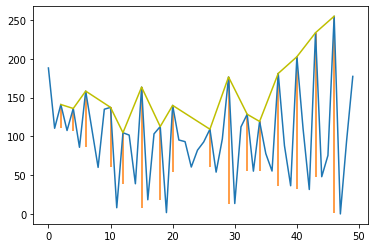

Underhand Bowling
Peak Values:
[213.39185605]
Vert distance between peaks:
[]
Avg vert distance btw peaks for whole trial:
nan


C:\Users\dusti\anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\dusti\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


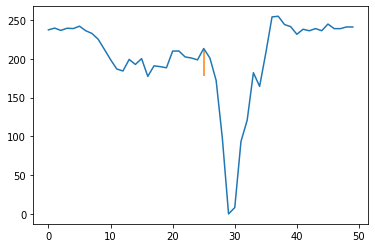

Underhand Bowling
Peak Values:
[228.28705179 252.7380206 ]
Vert distance between peaks:
[24.45096881]
Avg vert distance btw peaks for whole trial:
24.450968808135826


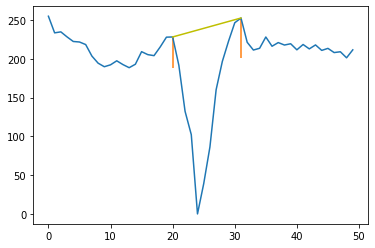

Underhand Bowling
Peak Values:
[229.11095913 255.00142602]
Vert distance between peaks:
[25.89046689]
Avg vert distance btw peaks for whole trial:
25.8904668887738


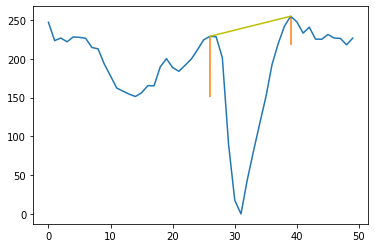

Underhand Bowling
Peak Values:
[221.4015607  255.00405757]
Vert distance between peaks:
[33.60249687]
Avg vert distance btw peaks for whole trial:
33.60249686694641


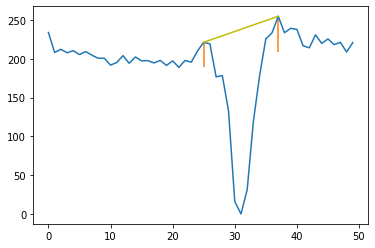

Underhand Bowling
Peak Values:
[234.06824713 211.54223496 224.30119535]
Vert distance between peaks:
[22.52601217 12.75896039]
Avg vert distance btw peaks for whole trial:
17.642486277454097


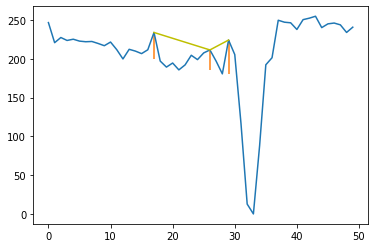

In [19]:
# Look at distance between vertical peaks:

peak_prominence = 25

for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    #print(gesture_name)
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    for trial in trials:        
        peaks, properties = signal.find_peaks(trial.accel.y_p, prominence=peak_prominence)
        print(gesture_name)
#         print(trial.accel.y_p[peaks])
        print("Peak Values:")
        peak_vals = np.take(trial.accel.y_p, signal.find_peaks(trial.accel.y_p, prominence=peak_prominence)[0])
        print(peak_vals)
        print("Vert distance between peaks:")
        vert_distances = np.abs(np.diff(peak_vals))
        print(vert_distances)
        print("Avg vert distance btw peaks for whole trial:")
        avg_vert_dist = np.average(vert_distances)
        print(avg_vert_dist)
        plt.plot(trial.accel.y_p)
        plt.plot(peaks, trial.accel.y_p[peaks], "y")
        plt.vlines(x=peaks, ymin=trial.accel.y_p[peaks] - properties["prominences"],
                   ymax = trial.accel.y_p[peaks], color = "C1")
        plt.show()

Samples:  40  | Prominence:  20


C:\Users\dusti\anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\dusti\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


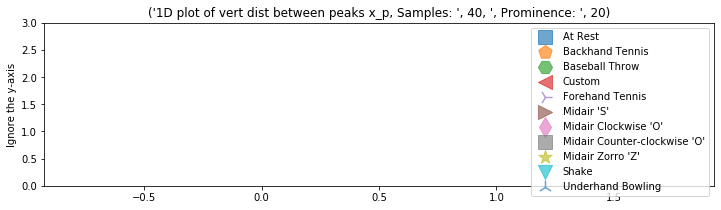

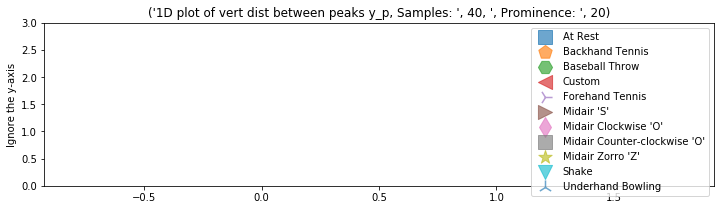

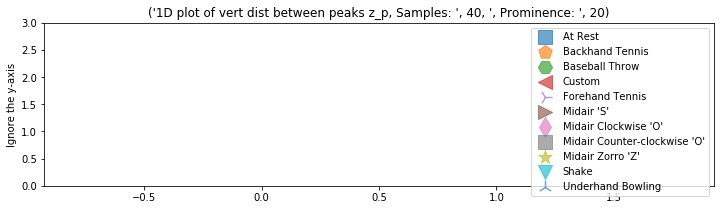

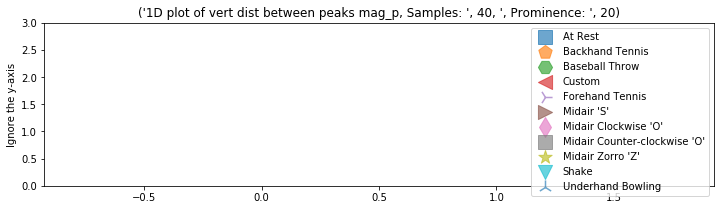

Samples:  40  | Prominence:  25


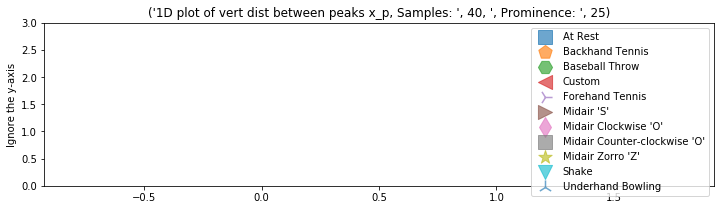

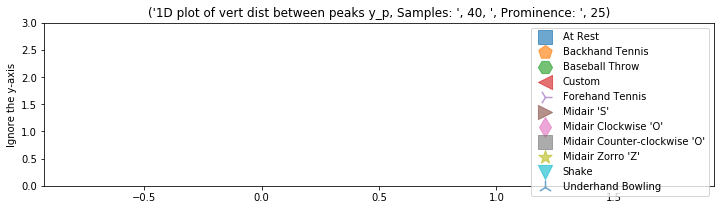

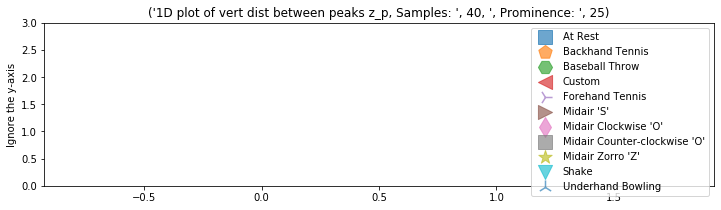

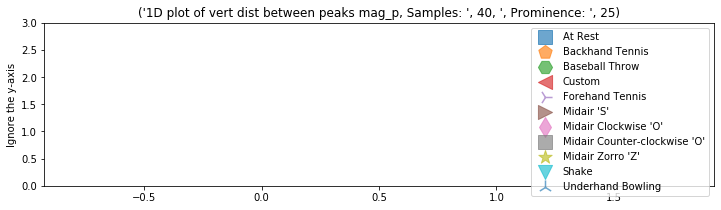

Samples:  40  | Prominence:  35


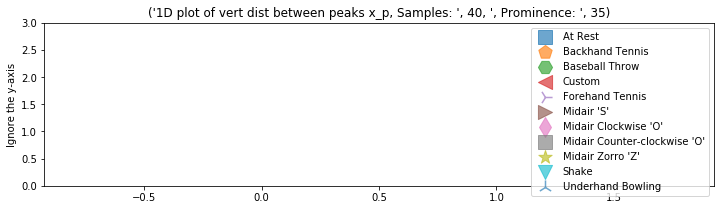

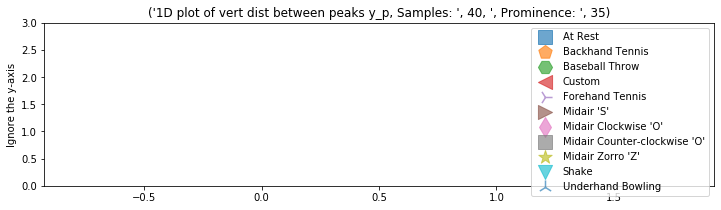

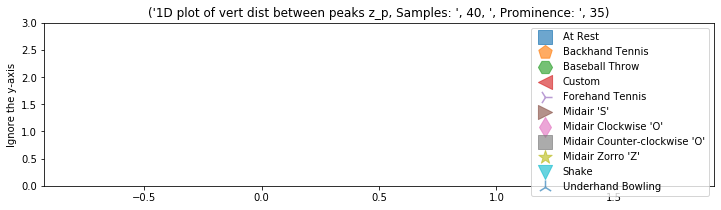

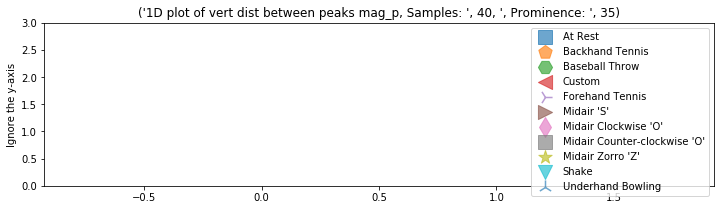

Samples:  50  | Prominence:  20


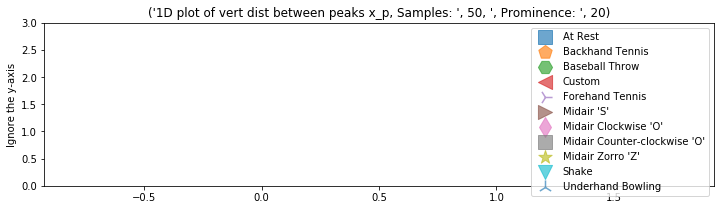

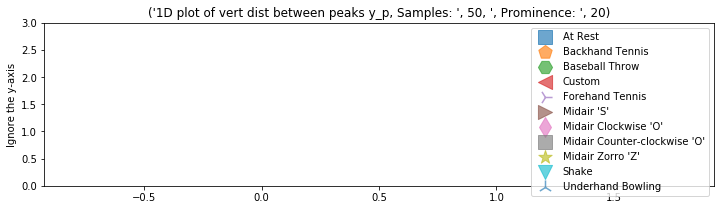

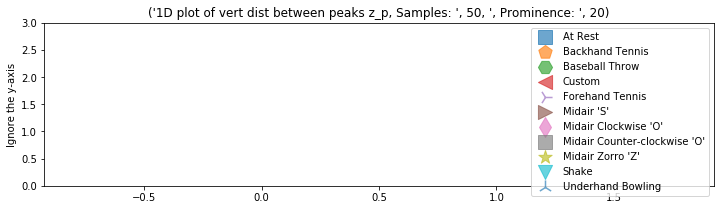

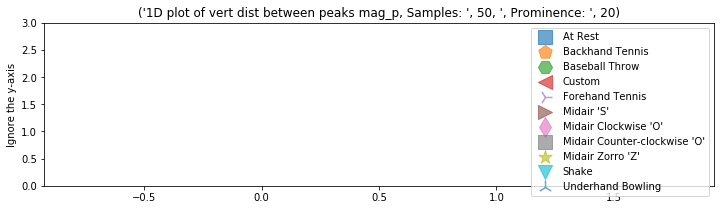

Samples:  50  | Prominence:  25


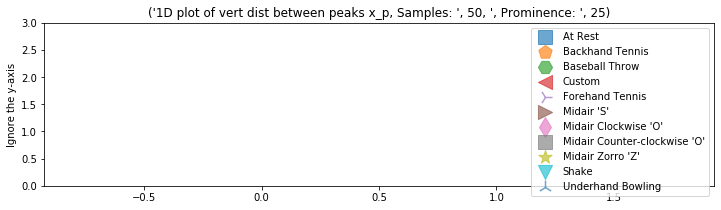

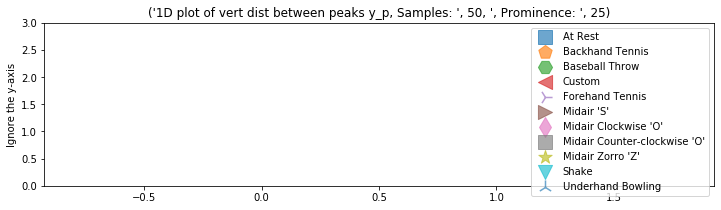

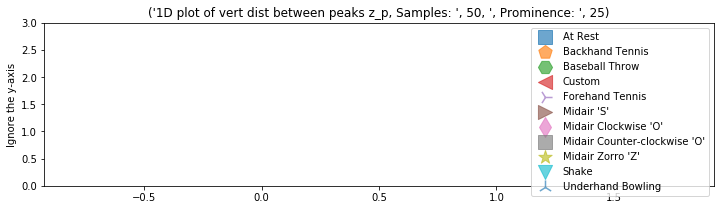

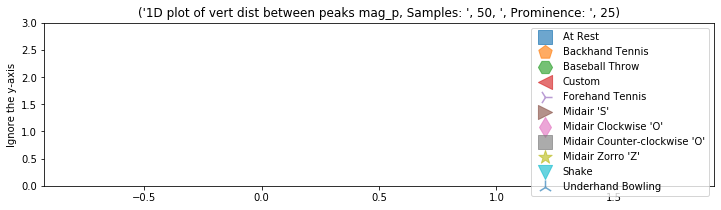

Samples:  50  | Prominence:  35


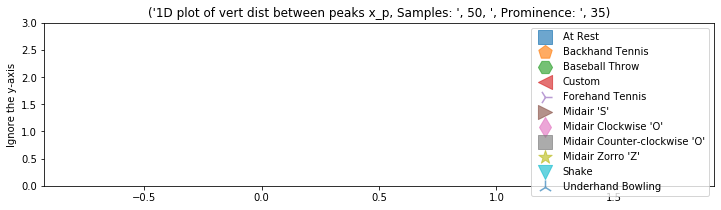

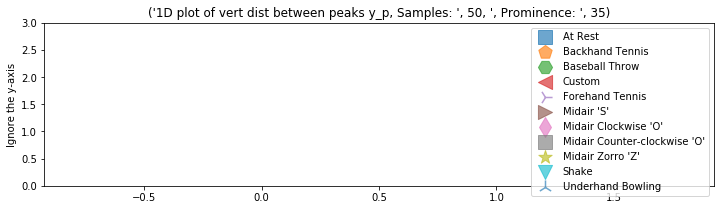

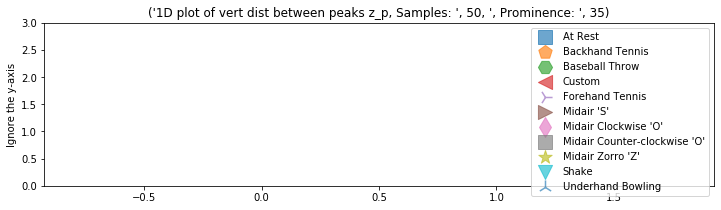

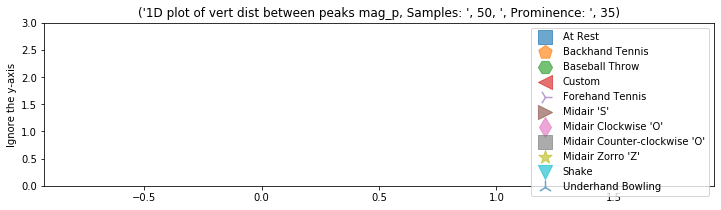

Samples:  60  | Prominence:  20


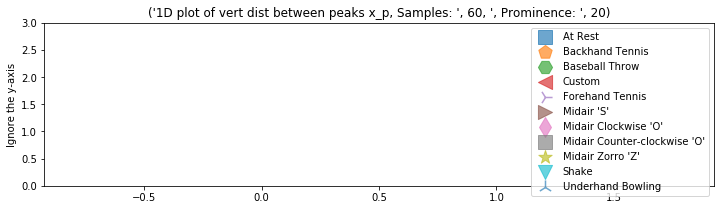

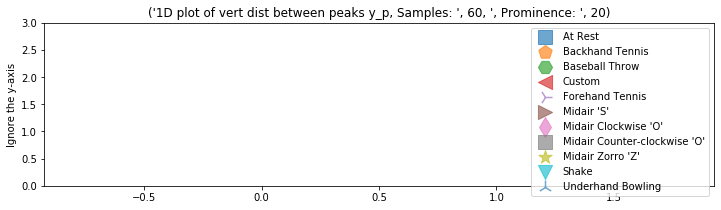

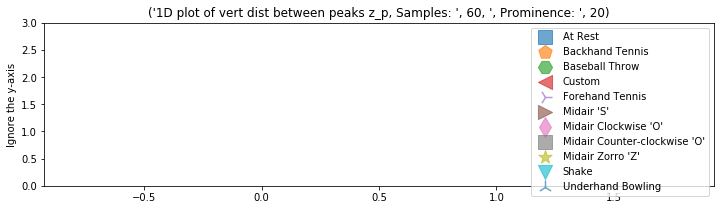

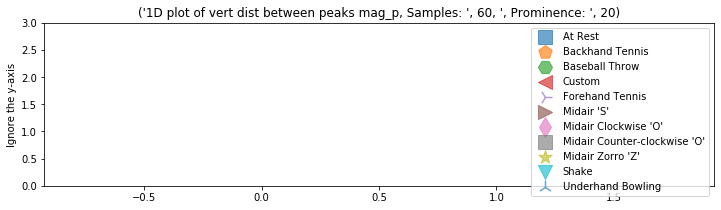

Samples:  60  | Prominence:  25


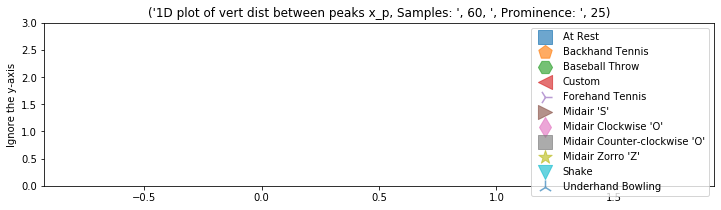

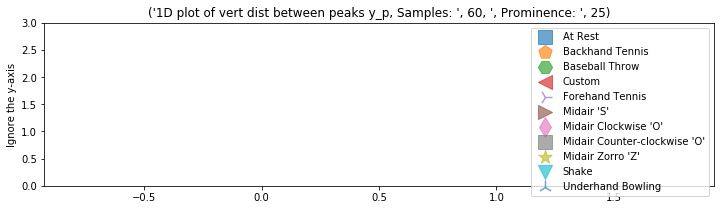

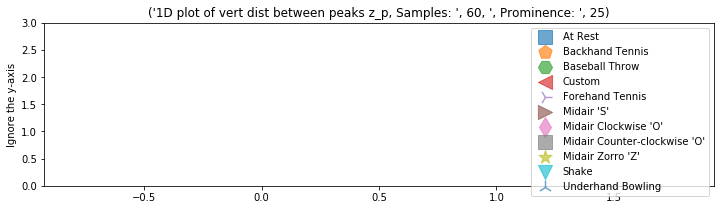

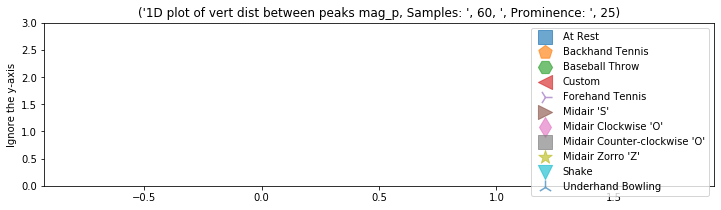

Samples:  60  | Prominence:  35


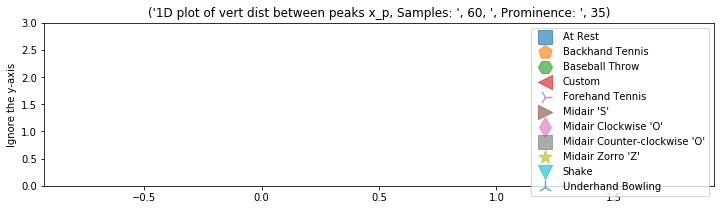

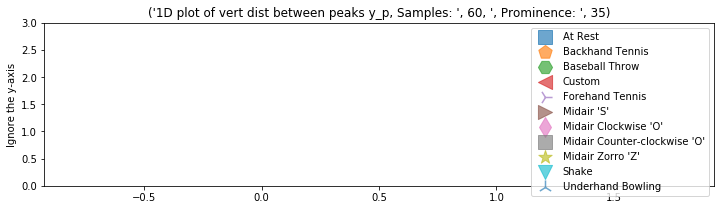

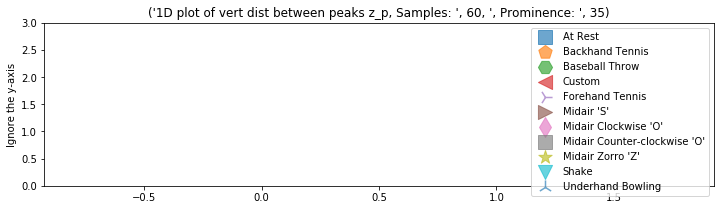

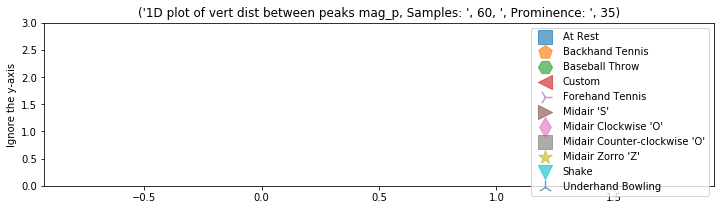

In [50]:
# First attempt:
# resampling_values = [30, 50, 100]
# prominence_values = [25, 50]

# First attempt results:
# Best values: z_p, samples: 50, prominence: 25

# Second attempt:
resampling_values = [40, 50, 60]
prominence_values = [20, 25, 35]

# Second attempt results:
# Nothing significantly better than first attempt.

# Define Lambda Functions
extract_feature_peaks_avg_vert_dist_x_p = lambda accel_trial: np.average(np.abs(np.diff(np.take(accel_trial.x_p, signal.find_peaks(accel_trial.x_p, prominence=peak_prominence)[0]))))
extract_feature_peaks_avg_vert_dist_y_p = lambda accel_trial: np.average(np.abs(np.diff(np.take(accel_trial.y_p, signal.find_peaks(accel_trial.y_p, prominence=peak_prominence)[0]))))
extract_feature_peaks_avg_vert_dist_z_p = lambda accel_trial: np.average(np.abs(np.diff(np.take(accel_trial.z_p, signal.find_peaks(accel_trial.z_p, prominence=peak_prominence)[0]))))
extract_feature_peaks_avg_vert_dist_mag_p = lambda accel_trial: np.average(np.abs(np.diff(np.take(accel_trial.mag_p, signal.find_peaks(accel_trial.mag_p, prominence=peak_prominence)[0]))))

# For-loop for finding best hyperparameters
for sampling_freq in resampling_values:
    for prominence_val in prominence_values:
        print("Samples: ", sampling_freq, " | Prominence: ", prominence_val)
        # Preprocess data with this sampling frequency
        for gesture_set in map_gesture_sets.values():
            for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
                for trial in trials:
                    preprocess_trial(trial, sampling_freq=sampling_freq, normalization="-1<x<1")
        # Plot graphs for this frequency/prominence combination
        plot_feature_1d(selected_gesture_set, extract_feature_peaks_avg_vert_dist_x_p, 
                title = ("1D plot of vert dist between peaks x_p, Samples: ", sampling_freq, ", Prominence: ", prominence_val))
        plot_feature_1d(selected_gesture_set, extract_feature_peaks_avg_vert_dist_y_p, 
                title = ("1D plot of vert dist between peaks y_p, Samples: ", sampling_freq, ", Prominence: ", prominence_val))
        plot_feature_1d(selected_gesture_set, extract_feature_peaks_avg_vert_dist_z_p, 
                title = ("1D plot of vert dist between peaks z_p, Samples: ", sampling_freq, ", Prominence: ", prominence_val))
        plot_feature_1d(selected_gesture_set, extract_feature_peaks_avg_vert_dist_mag_p, 
                title = ("1D plot of vert dist between peaks mag_p, Samples: ", sampling_freq, ", Prominence: ", prominence_val))

#### Number of zero crossings

Best results: mag_p with 60 samples

In [51]:
# The current pre-processing normalizes values 0-255.
# Instead, let's normalize from -1 < x < 1:

for gesture_set in map_gesture_sets.values():
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        for trial in trials:
            preprocess_trial(trial, sampling_freq=50, normalization="-1<x<1")

Text(0.5, 1.0, 'JonGestures: Baseball Throw (accel mag_p)')

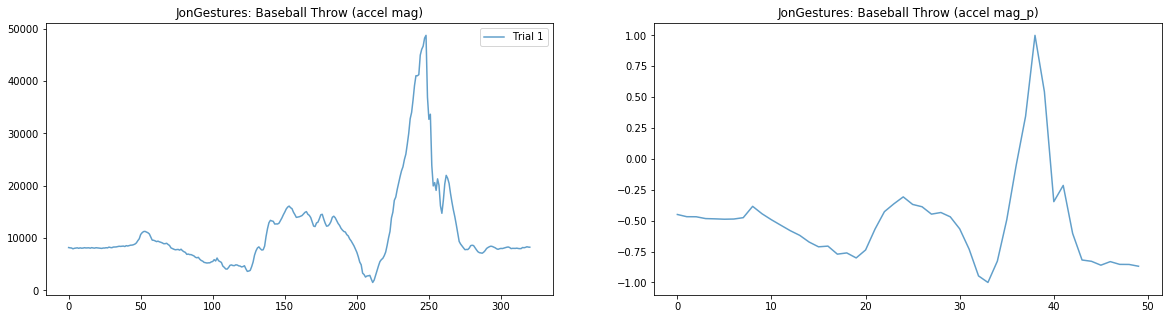

In [52]:
# Next, visualize the data for a sanity check:

rand_gesture_name = selected_gesture_set.get_random_gesture_name()
#rand_gesture_name = "Underhand Bowling"

# We'll make a 1x2 grid of plots, so pass 1,2 to subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 5)) #figsize is width, height
rand_trial = selected_gesture_set.get_random_trial_for_gesture(rand_gesture_name)
#rand_trial = selected_gesture_set.get_trials_for_gesture(rand_gesture_name)[2]

axes[0].plot(rand_trial.accel.mag, alpha=0.7, label="Trial {}".format(rand_trial.trial_num))
axes[0].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (accel mag)")
axes[0].legend()

axes[1].plot(rand_trial.accel.mag_p, alpha=0.7, label="Trial {}".format(rand_trial.trial_num))
axes[1].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (accel mag_p)")

Samples:  40


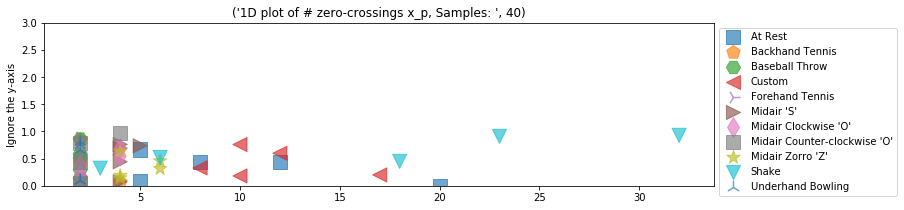

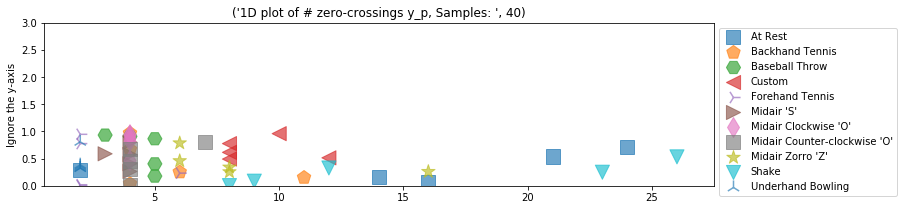

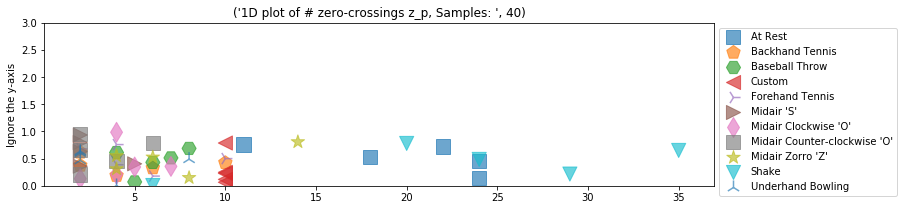

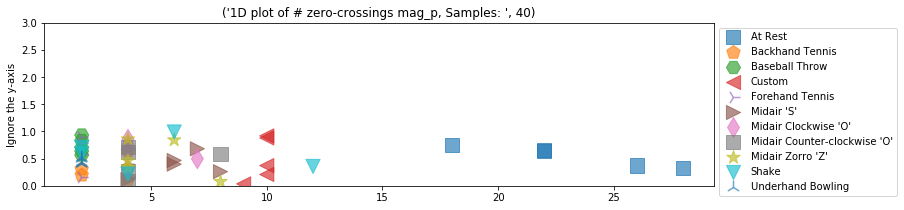

Samples:  50


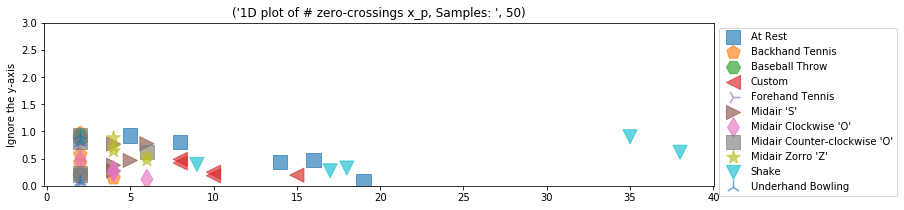

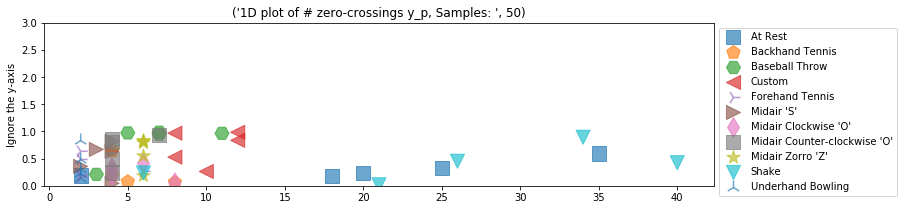

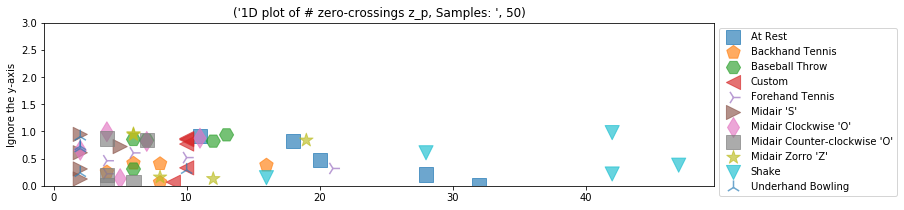

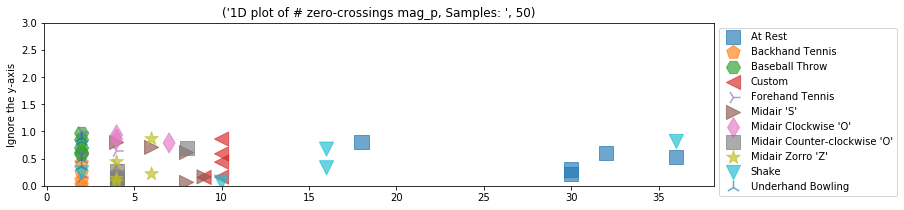

Samples:  60


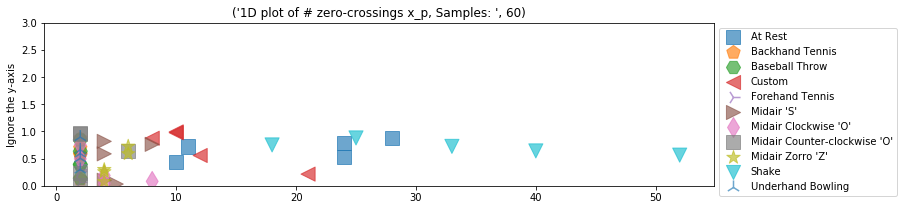

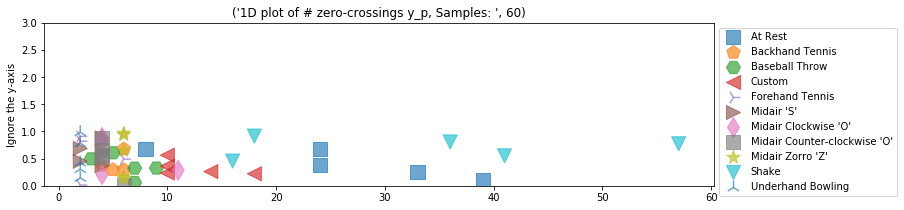

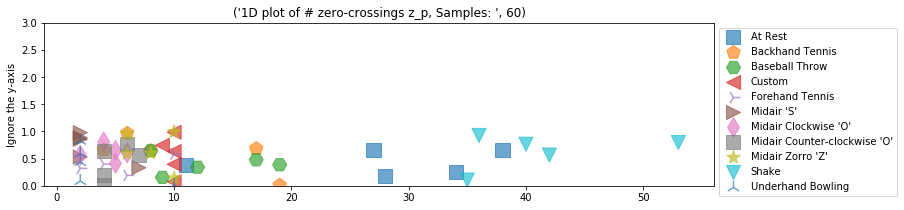

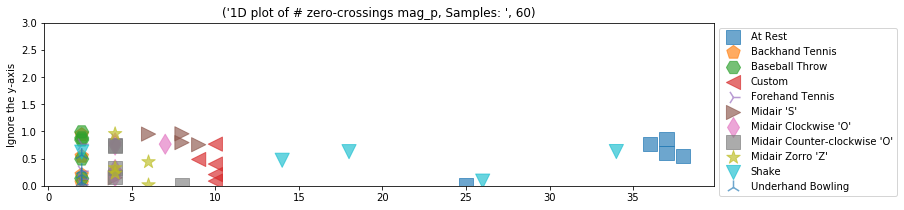

In [53]:
# Now calculate 0 crossings.
# Counting zero-crossings algo thanks to Mike Müller, found here:
# https://stackoverflow.com/questions/30272538/python-code-for-counting-number-of-zero-crossings-in-an-array

# First attempt:
# resampling_values = [30, 50, 100]

# First attempt results:
# Best values: mag_p at 50 samples

# Second attempt:
resampling_values = [40, 50, 60]

# Second attempt results:
# mag_p, 60 samples might be slightly better

# Define Lambda Functions
extract_feature_zero_cross_x_p = lambda accel_trial: ((accel_trial.x_p[:-1] * accel_trial.x_p[1:]) < 0).sum()
extract_feature_zero_cross_y_p = lambda accel_trial: ((accel_trial.y_p[:-1] * accel_trial.y_p[1:]) < 0).sum()
extract_feature_zero_cross_z_p = lambda accel_trial: ((accel_trial.z_p[:-1] * accel_trial.z_p[1:]) < 0).sum()
extract_feature_zero_cross_mag_p = lambda accel_trial: ((accel_trial.mag_p[:-1] * accel_trial.mag_p[1:]) < 0).sum()

# For-loop for finding best hyperparameters
for sampling_freq in resampling_values:
    print("Samples: ", sampling_freq)
    # Preprocess data with this sampling frequency
    for gesture_set in map_gesture_sets.values():
        for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
            for trial in trials:
                preprocess_trial(trial, sampling_freq=sampling_freq, normalization="-1<x<1")
    # Plot graphs for this frequency/prominence combination
    plot_feature_1d(selected_gesture_set, extract_feature_zero_cross_x_p, 
            title = ("1D plot of # zero-crossings x_p, Samples: ", sampling_freq))
    plot_feature_1d(selected_gesture_set, extract_feature_zero_cross_y_p, 
            title = ("1D plot of # zero-crossings y_p, Samples: ", sampling_freq))
    plot_feature_1d(selected_gesture_set, extract_feature_zero_cross_z_p, 
            title = ("1D plot of # zero-crossings z_p, Samples: ", sampling_freq))
    plot_feature_1d(selected_gesture_set, extract_feature_zero_cross_mag_p, 
            title = ("1D plot of # zero-crossings mag_p, Samples: ", sampling_freq))

## Frequency domain

Of course, there may also be discriminable information in the frequency domain. If you haven't already, complete our [Frequency Analysis](https://makeabilitylab.github.io/physcomp/signals/FrequencyAnalysis/index.html) lesson before moving forward.

Just as we brainstormed time domain features, how about features in the frequency domain, such as:
- The top frequency (*i.e.,* the frequency with the highest amplitude in the signal)
- The top N frequencies (overall or within some frequency band)
- The lowest/highest frequency (over some amplitude threshold)
- Number of frequency peaks (over a certain amplitude threshold)
- Avg value of frequency peaks
- Or perhaps a sliding window that breaks up the signal into chunks and extracts frequency information over each chunk
- And many others...

### Visualizing frequency information 

Let's start—as we always should—by plotting our signals and exploring some initial stats.

Below, we plot a visualization grid where each column is a gesture trial and rows alternate between the time domain and frequency domain versions of the `mag` for that gesture.

In [54]:
# First, let's renormalize pre-processed data to the scale 0-255:

for gesture_set in map_gesture_sets.values():
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        for trial in trials:
            preprocess_trial(trial, sampling_freq=50, normalization="-1<x<1")

IntProgress(value=0, max=22)

Selected gesture set: JonGestures


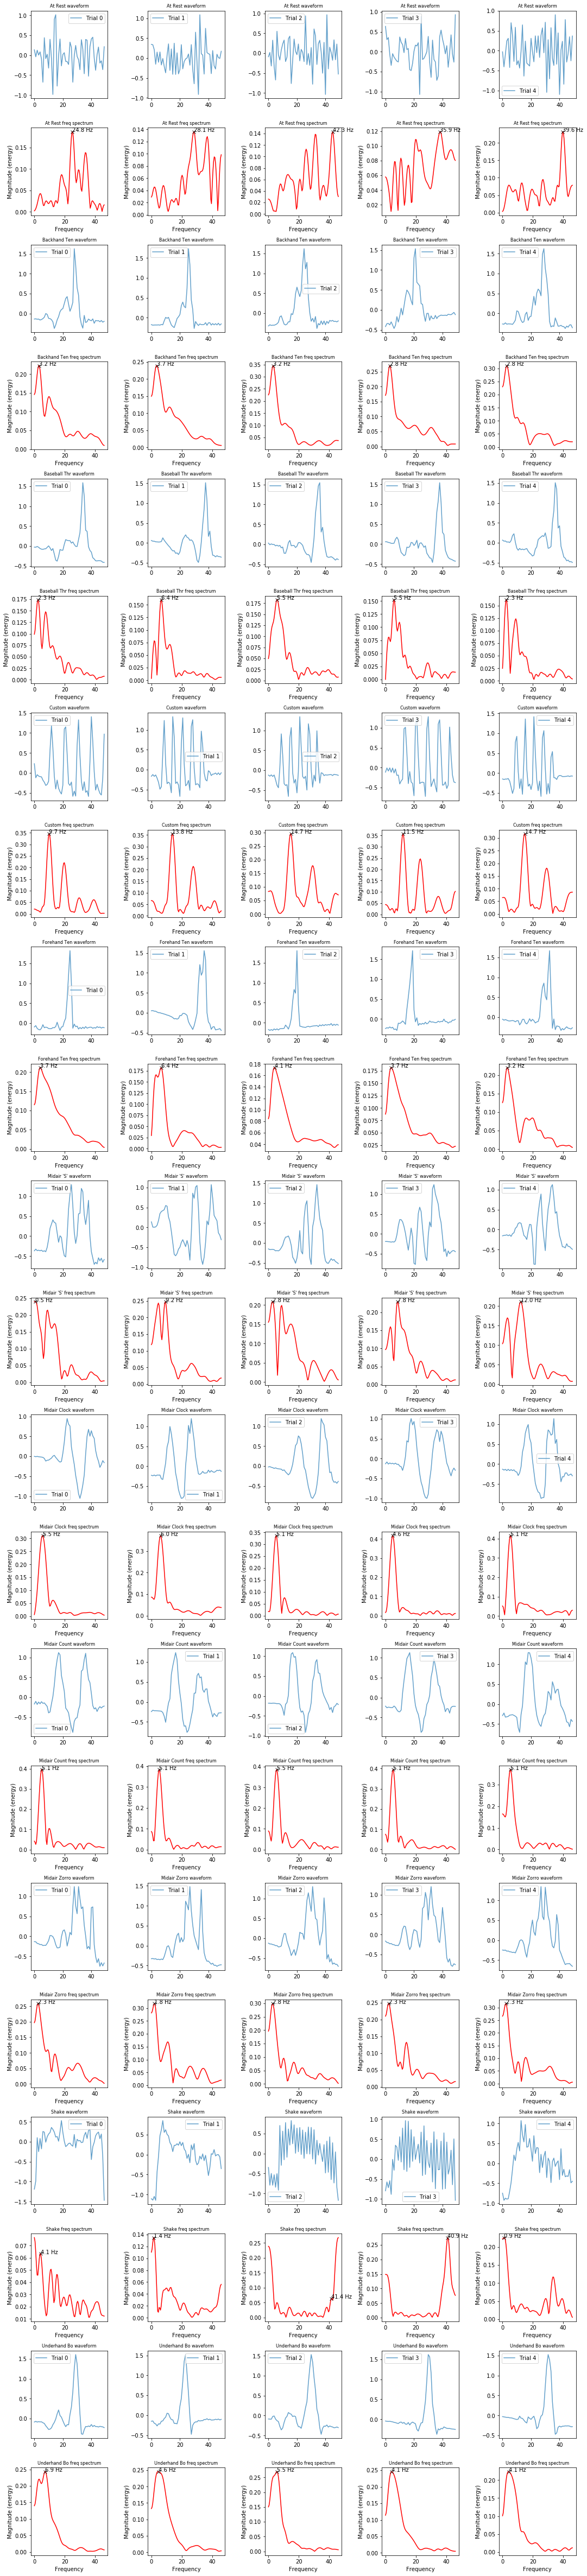

In [55]:
# This cell will take a bit of time not because of the frequency analysis but because
# of preparing the large matplotlib image
import IPython.display as ipd
import ipywidgets

num_cols = 5 # 1 col for each gesture trial 
num_rows = selected_gesture_set.get_num_gestures() * 2 # 1 for waveform, 1 for frequency per gesture
row_height = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, row_height * num_rows))

index = 0
sampling_rate = 92 # roughly 92
progress_bar = ipywidgets.IntProgress(value=0, min=0, max=num_rows)
ipd.display(progress_bar)
title_font_size = 8
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    gesture_trials = selected_gesture_set.get_trials_for_gesture(gesture_name)
    
    for trial in gesture_trials:
        s = trial.accel.mag_p # change this to visualize/explore other signals
        ax = axes[index][trial.trial_num]
        
        # remove "DC offset" to perform FFT
        s_removed_offset = s - np.mean(s)
        
        ax.plot(s_removed_offset, alpha=0.7, label=f"Trial {trial.trial_num}")
        ax.set_title(f"{gesture_name[0:12]} waveform", fontsize= title_font_size)
        ax.legend()
        
        sampling_rate = math.ceil(trial.accel.sampling_rate)
        ax = axes[index + 1][trial.trial_num]
        spectrum, freqs_of_spectrum, line = ax.magnitude_spectrum(s_removed_offset, Fs = sampling_rate, 
                                                        color='r', pad_to = 4 * len(s))
        ax.set_title(f"{gesture_name[0:12]} freq spectrum", fontsize= title_font_size)
        
        # Annotate the top freq (by amplitude) on each graph
        top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, freqs_of_spectrum, spectrum)
        top_freq = top_n_freq_with_amplitudes[0][0]
        top_amplitude = top_n_freq_with_amplitudes[0][1]
        ax.plot(top_freq, top_amplitude, marker="x", color="black", alpha=0.8)
        ax.text(top_freq, top_amplitude, f"{top_freq:0.1f} Hz", color="black")
      
    index = index + 2 
    progress_bar.value = index
    
fig.tight_layout(pad=1)

print(f"Selected gesture set: {selected_gesture_set.name}")

### Feature: top frequency
As one example, let's extract the most prominent (highest-amplitude) frequency for each gesture using the magnitude part of the accelerometer signal.

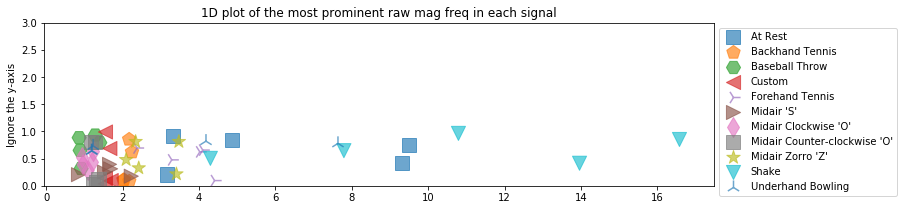

In [56]:
def extract_feature_top_mag_freq(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_freq, 
                title = "1D plot of the most prominent raw mag freq in each signal")

You might be surprised to see *At Rest's* position in the graph. This is because we do not take into account the *strength* of the frequency component for each signal. The identified frequencies in *At Rest* are low amplitude (and largely noise).

To control for this, we can add in a parameter to `get_top_n_frequency_peaks` to filter out identified frequencies of less than a certain amplitude coefficient. In this case, let's try `500` but you should experiment with any thresholds used in your code.

JonGestures


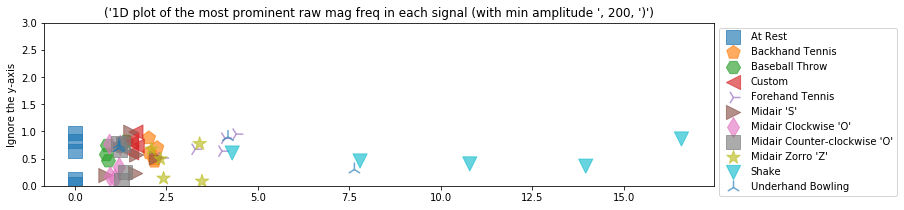

In [57]:
# min_amp_threshold = 500
min_amp_threshold = 200

def extract_feature_top_mag_freq2(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes, min_amplitude_threshold = min_amp_threshold)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

print(selected_gesture_set.name)

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_freq2, 
                title = ("1D plot of the most prominent raw mag freq in each signal (with min amplitude ", min_amp_threshold, ")"))

We are able to see roughly four groupings here:
- The *At Rest* group
- A second cluster with frequencies between ~0.5 and 2.5 Hz
- Possibly a third cluster with *Zorro* and *Forehand Tennis* between ~2.5 and 5 Hz
- And another clear outlier cluster for *Shake* with freq between ~5-15 Hz

Let's zoom into the x-axis a bit to explore the middle cluster more closely.

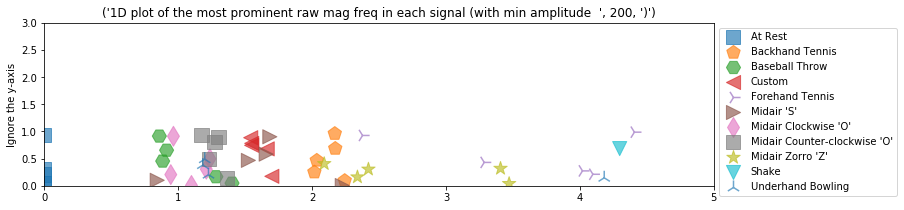

In [58]:
plot_feature_1d(selected_gesture_set, extract_feature_top_mag_freq2, 
                title = ("1D plot of the most prominent raw mag freq in each signal (with min amplitude  ", min_amp_threshold, ")"),
                xlim = (0, 5))

We can, of course, perform frequency analyses on any other signal—be it `x`, `y`, `z`, `mag` or some processed version. For example, here's a frequency analysis of a preprocessed `mag_p` signal.

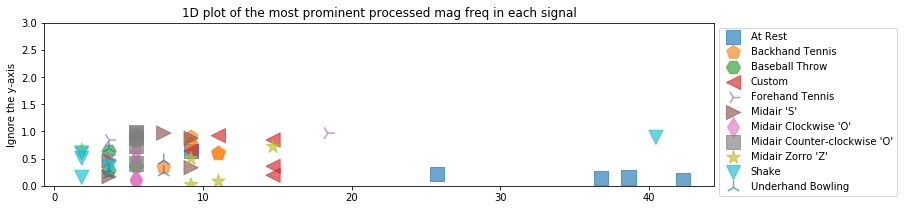

In [59]:
def extract_feature_top_mag_p_freq(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag_p, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes, min_amplitude_threshold = .05)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(5, fft_freqs, fft_amplitudes)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_p_freq, 
                title = "1D plot of the most prominent processed mag freq in each signal")

### Brainstorm and plot your own frequency domain features

What other features can you think of for the frequency domain?

#### The lowest frequency (over some amplitude threshold)

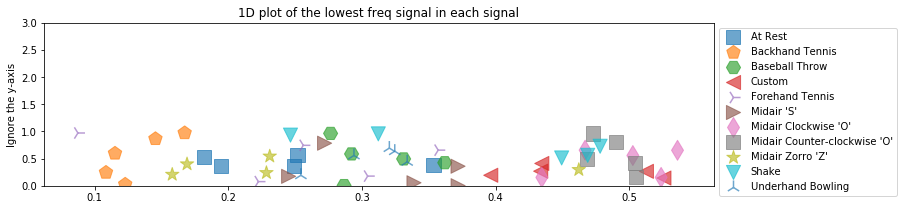

In [60]:
def extract_feature_lowest_freq_over_thresh(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag_p, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(10, fft_freqs, fft_amplitudes, min_amplitude_threshold = .05)
    lowest_freq = np.min(top_n_freq_with_amplitudes[0])

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return lowest_freq

# for gesture_name in selected_gesture_set.get_gesture_names_sorted():
#     gesture_trials = selected_gesture_set.get_trials_for_gesture(gesture_name)
#     for trial in gesture_trials:
#         extract_feature_top_n_freq(trial.accel)

plot_feature_1d(selected_gesture_set, extract_feature_lowest_freq_over_thresh, 
                title = "1D plot of the lowest freq signal in each signal")

#### The highest frequency (over some amplitude threshold)

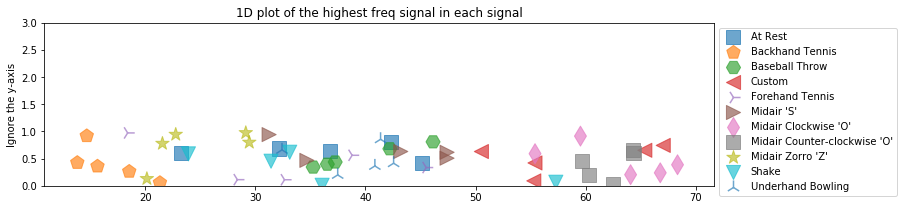

In [32]:
def extract_feature_highest_freq_over_thresh(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag_p, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(10, fft_freqs, fft_amplitudes, min_amplitude_threshold = .05)
    lowest_freq = np.max(top_n_freq_with_amplitudes[0])

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return lowest_freq

plot_feature_1d(selected_gesture_set, extract_feature_highest_freq_over_thresh, 
                title = "1D plot of the highest freq signal in each signal")

#### Number of frequency peaks (over a certain amplitude threshold)

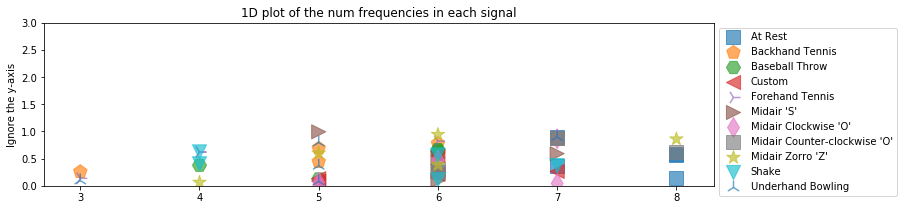

In [33]:
def extract_feature_num_freq_over_thresh(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag_p, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(10, fft_freqs, fft_amplitudes, min_amplitude_threshold = .04)
    num_peaks = len(top_n_freq_with_amplitudes)
#     print(num_peaks)
    

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return num_peaks

# for gesture_name in selected_gesture_set.get_gesture_names_sorted():
#     gesture_trials = selected_gesture_set.get_trials_for_gesture(gesture_name)
#     for trial in gesture_trials:
#         extract_feature_num_freq_over_thresh(trial.accel)

plot_feature_1d(selected_gesture_set, extract_feature_num_freq_over_thresh, 
                title = "1D plot of the num frequencies in each signal")

#### HUH?

In [34]:
def extract_feature_top_freq(s, sampling_rate, min_amplitude_threshold = 500):
    (fft_freqs, fft_amplitudes) = grsignalproc.compute_fft(s, sampling_rate)
    top_n_freq_with_amplitudes = grsignalproc.get_top_n_frequency_peaks(1, fft_freqs, 
                                                           fft_amplitudes, 
                                                           min_amplitude_threshold = min_amplitude_threshold)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

#### Avg value of frequency peaks

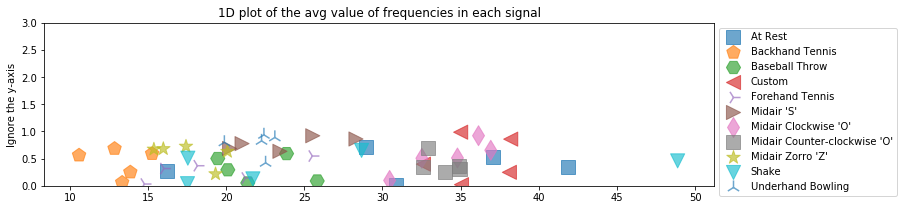

In [35]:
def extract_feature_avg_val_freq_over_thresh(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag_p, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(10, fft_freqs, fft_amplitudes, min_amplitude_threshold = .05)
    avg_value = np.average(top_n_freq_with_amplitudes[0])
#     print(avg_value)
    

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return avg_value

# for gesture_name in selected_gesture_set.get_gesture_names_sorted():
#     gesture_trials = selected_gesture_set.get_trials_for_gesture(gesture_name)
#     for trial in gesture_trials:
#         extract_feature_num_freq_over_thresh(trial.accel)

plot_feature_1d(selected_gesture_set, extract_feature_avg_val_freq_over_thresh, 
                title = "1D plot of the avg value of frequencies in each signal")

#### Std deviation of frequency peaks

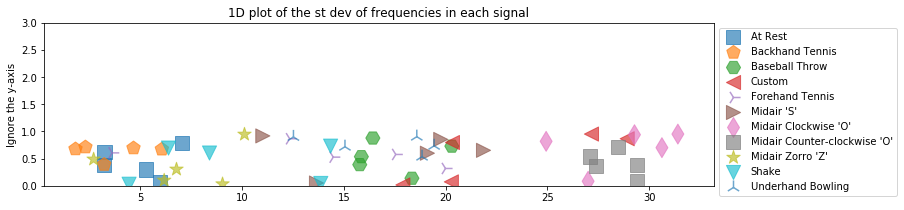

In [36]:
def extract_feature_stdev_freq_over_thresh(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag_p, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(10, fft_freqs, fft_amplitudes, min_amplitude_threshold = .04)
    st_dev = np.std(top_n_freq_with_amplitudes[0])
#     print(avg_value)
    

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return st_dev

# for gesture_name in selected_gesture_set.get_gesture_names_sorted():
#     gesture_trials = selected_gesture_set.get_trials_for_gesture(gesture_name)
#     for trial in gesture_trials:
#         extract_feature_num_freq_over_thresh(trial.accel)

plot_feature_1d(selected_gesture_set, extract_feature_stdev_freq_over_thresh, 
                title = "1D plot of the st dev of frequencies in each signal")

## 2-dimensional explorations

OK, now that we've built up some familiarity with feature extraction and how these features may enable us to discriminate gestures, let's plot various combinations of them in 2D. Again, remember that our classifiers will (often) work in N-dimensions where N is the number of features. But it's just not possible for us to visualize all of our features at once in an N-dimensional graph.

But at least we're going from 1D to 2D, wee! :)

We'll begin by just randomly choosing some features to plot together: how about the standard deviation of the accel `mag` and the max `mag`?

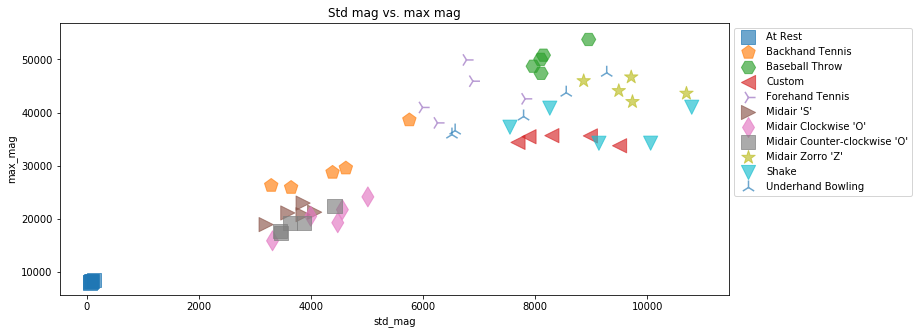

In [37]:
plot_feature_2d(selected_gesture_set, extract_feature_std_mag, extract_feature_max_mag,
               xlabel="std_mag", ylabel="max_mag", title="Std mag vs. max mag")

Again, our goal here is to see clear clusters emerging—ideally where each cluster is composed of the same gesture class and the clusters themselves have clear separation.

Let's try another combination. How about the max `mag` frequency component (in frequency domain) and the max `mag` signal value (in the time domain).

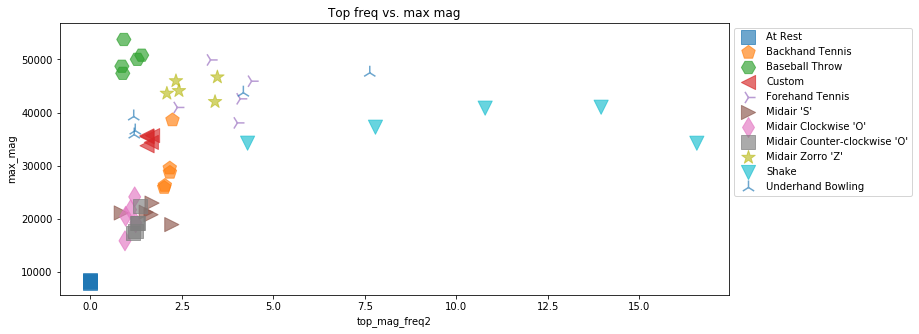

In [38]:
# plot_feature_2d(selected_gesture_set, extract_feature_top_mag_freq2, extract_feature_std_mag,
#                xlabel="extract_feature_top_mag_freq2", ylabel="max_mag", title="Std mag vs. max mag")

plot_feature_2d(selected_gesture_set, extract_feature_top_mag_freq2, extract_feature_max_mag,
               xlabel="top_mag_freq2", ylabel="max_mag", title="Top freq vs. max mag")

Again, now it's up to you. Try graphing some feature combinations below.

#### Num peaks vs mean magnitude

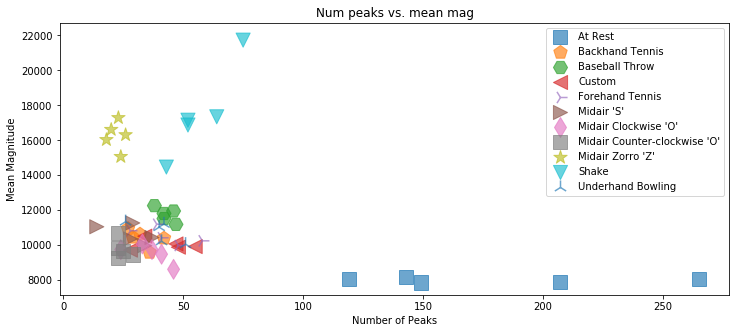

In [39]:
plot_feature_2d(selected_gesture_set, extract_feature_peaks_mag, extract_feature_mean_mag,
               xlabel="Number of Peaks", ylabel="Mean Magnitude", title="Num peaks vs. mean mag")

#### Standard deviation y vs. mean magnitude

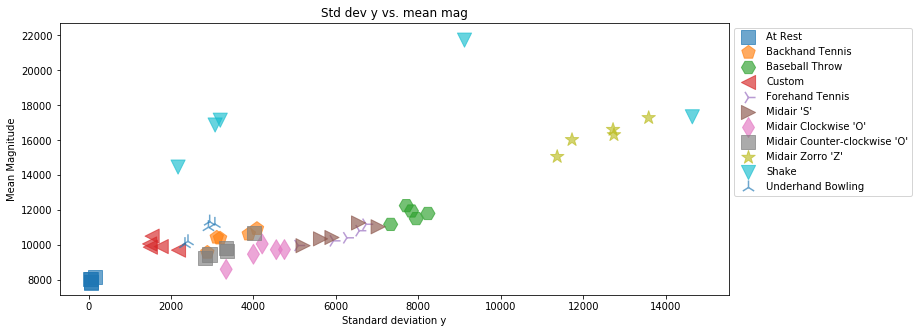

In [40]:
plot_feature_2d(selected_gesture_set, extract_feature_stdev_y, extract_feature_mean_mag,
               xlabel="Standard deviation y", ylabel="Mean Magnitude", title="Std dev y vs. mean mag")

#### Num peaks y vs. standard dev y

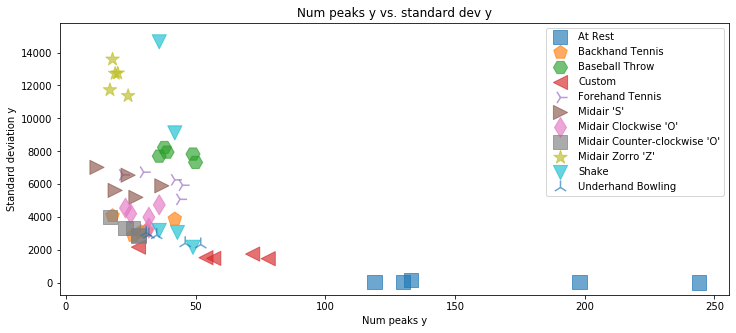

In [41]:
plot_feature_2d(selected_gesture_set, extract_feature_peaks_y, extract_feature_stdev_y,
               xlabel="Num peaks y", ylabel="Standard deviation y", title="Num peaks y vs. standard dev y")

## Pandas

At risk of introducing too many frameworks and libraries in this course (I know!), we had to bring in one more: [pandas](https://pandas.pydata.org/)—one of the most popular open-source data analysis tools in data science. And pandas builds on and uses SciPy libraries.

Rest assured, we are *barely* going to use pandas. But we are going to use pandas [DataFrame](https://pandas.pydata.org/docs/getting_started/dsintro.html#dataframe) data structures, which are 2-dimensional tables a bit like a spreadsheet or an SQL table. They support querying, filtering, *etc.* but we mainly use them because it makes interacting with Scikit-learn easier (in our humble opinions, at least).

And again, don't worry. We show you everything you need to know below. You can certainly dive deeper, if you want. Knowing pandas gives you major data science street cred. :) 

While not necessary, you may want to check out the official [10-minute pandas tutorial](https://pandas.pydata.org/docs/getting_started/dsintro.html) or just dive in below.

### Create pandas DataFrame of features
Below, we build a pandas DataFrame table of our features. This is just a small playground. The *real* feature extraction code that we use in our classification experiments is found below in the sub-section entitled [Feature extraction code](#Feature-extraction-code).

In [42]:
df = None
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    
    for trial in trials:
        features = dict()
        features["gesture_set"] = selected_gesture_set.name
        features["gesture"] = gesture_name
        features["trial_num"] = trial.trial_num
        features["signal_length (samples)"] = extract_feature_signal_length(trial.accel)
        features["signal_length (secs)"] = trial.accel.length_in_secs
        features["max_mag"] = extract_feature_max_mag(trial.accel)
        features["max_mag_p"] = np.max(trial.accel.mag_p)
        features["std_mag"] = extract_feature_std_mag(trial.accel)
        features["top_mag_freq"] = extract_feature_top_mag_freq2(trial.accel)
        
        if df is None:
            df = pd.DataFrame([features])
        else:
            df = df.append(features, ignore_index=True)

# Calling display on a DataFrame creates a pretty HTML-formatted table!
# Print out only the first 11 rows
display(df.head(n = 11))


gesture_set          gesture  trial_num  signal_length (samples)  \
0   JonGestures          At Rest          0                      407   
1   JonGestures          At Rest          1                      702   
2   JonGestures          At Rest          2                      529   
3   JonGestures          At Rest          3                      889   
4   JonGestures          At Rest          4                      678   
5   JonGestures  Backhand Tennis          0                      226   
6   JonGestures  Backhand Tennis          1                      246   
7   JonGestures  Backhand Tennis          2                      254   
8   JonGestures  Backhand Tennis          3                      228   
9   JonGestures  Backhand Tennis          4                      212   
10  JonGestures   Baseball Throw          0                      287   

    signal_length (secs)       max_mag   max_mag_p      std_mag  top_mag_freq  
0                  4.466   8392.926546  255.679178    85.980464      0.000000  
1                  7.711   8065.111035  256.052480    63.786350      0.000000  
2                  5.808   8032.764904  255.264814    54.831833      0.000000  
3                  9.767   8360.118659  256.291395    73.913550      0.000000  
4                  7.447   8489.624727  255.446473   122.216694      0.000000  
5                  2.475  26276.710905  255.003103  3288.539127      2.035398  
6                  2.695  38608.822204  255.000750  5753.678656      2.243902  
7                  2.782  28739.692413  255.010113  4382.955449      2.173228  
8                  2.497  25896.547415  255.008924  3643.390332      2.017544  
9                  2.321  29550.215431  255.009175  4620.099892      2.169811  
10                 3.146  50026.128213  255.004140  8097.871597      1.282230

### Pandas groupby
Similar to SQL, you can create groupings using the [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) function and then use [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) to generate descriptive stats for each gesture (applied across all trials).

In [43]:
display(df.groupby('gesture').describe())

trial_num                                     \
                                 count mean       std  min  25%  50%  75%   
gesture                                                                     
At Rest                            5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Backhand Tennis                    5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Baseball Throw                     5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Custom                             5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Forehand Tennis                    5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Midair 'S'                         5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Midair Clockwise 'O'               5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Midair Counter-clockwise 'O'       5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Midair Zorro 'Z'                   5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Shake                              5.0  2.0  1.581139  0.0  1.0  2.0  3.0   
Underhand Bowling                  5.0  2.0  1.581139  0.0  1.0  2.0  3.0   

                                  signal_length (samples)         ...  \
                              max                   count   mean  ...   
gesture                                                           ...   
At Rest                       4.0                     5.0  641.0  ...   
Backhand Tennis               4.0                     5.0  233.2  ...   
Baseball Throw                4.0                     5.0  310.0  ...   
Custom                        4.0                     5.0  401.0  ...   
Forehand Tennis               4.0                     5.0  307.6  ...   
Midair 'S'                    4.0                     5.0  228.4  ...   
Midair Clockwise 'O'          4.0                     5.0  256.0  ...   
Midair Counter-clockwise 'O'  4.0                     5.0  218.0  ...   
Midair Zorro 'Z'              4.0                     5.0  209.4  ...   
Shake                         4.0                     5.0  436.0  ...   
Underhand Bowling             4.0                     5.0  273.8  ...   

                                   std_mag               top_mag_freq  \
                                       75%           max        count   
gesture                                                                 
At Rest                          85.980464    122.216694          5.0   
Backhand Tennis                4620.099892   5753.678656          5.0   
Baseball Throw                 8146.019378   8953.250953          5.0   
Custom                         8983.283719   9504.463251          5.0   
Forehand Tennis                6887.548095   7820.492792          5.0   
Midair 'S'                     3857.944275   4063.609066          5.0   
Midair Clockwise 'O'           4558.126944   5013.202213          5.0   
Midair Counter-clockwise 'O'   3871.854131   4418.847431          5.0   
Midair Zorro 'Z'               9735.167523  10698.269643          5.0   
Shake                         10059.275593  10792.644554          5.0   
Underhand Bowling              8553.183948   9275.356488          5.0   

                                                                       \
                                   mean       std       min       25%   
gesture                                                                 
At Rest                        0.000000  0.000000  0.000000  0.000000   
Backhand Tennis                2.127977  0.097472  2.017544  2.035398   
Baseball Throw                 1.068601  0.254194  0.859813  0.884615   
Custom                         1.601024  0.075402  1.541899  1.548822   
Forehand Tennis                3.637349  0.815709  2.377261  3.285714   
Midair 'S'                     1.587469  0.494601  0.844037  1.524862   
Midair Clockwise 'O'           1.091607  0.135087  0.945205  0.965035   
Midair Counter-clockwise 'O'   1.269345  0.072212  1.174468  1.232143   
Midair Zorro 'Z'               2.746010  0.645077  2.090909  2.338983   
Shake                       

### Pairwise correlation

We can use Pandas to calculate a pairwise correlation between features. Often, we want features that have low (near zero) correlation with one another. If multiple features are highly correlated, then they will not improve our classification performance (and will also slow down training).

The function [`df.corr()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) computes a pairwise correlation of columns (by default, using a [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), which measures the linear correlation between two variables).

For more on understanding the relationship between your input features and the Pearson correlation, read this [article](https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/) from Machine Learning Mastery.

In [44]:
# Pop a few things off the dataframe, which we don't want to include
# in our correlation analysis
if 'trial_num' in df:
    df.pop("trial_num")
if 'gesture' in df:
    df.pop('gesture')
if 'gesture_set' in df:
    df.pop('gesture_set')

# Compute and show the pairwise correlation table
corr = df.corr()
display(corr)


signal_length (samples)  signal_length (secs)  \
signal_length (samples)                 1.000000              1.000000   
signal_length (secs)                    1.000000              1.000000   
max_mag                                -0.269758             -0.269789   
max_mag_p                               0.756403              0.756388   
std_mag                                -0.277140             -0.277185   
top_mag_freq                            0.023607              0.023587   

                          max_mag  max_mag_p   std_mag  top_mag_freq  
signal_length (samples) -0.269758   0.756403 -0.277140      0.023607  
signal_length (secs)    -0.269789   0.756388 -0.277185      0.023587  
max_mag                  1.000000  -0.517840  0.883593      0.348711  
max_mag_p               -0.517840   1.000000 -0.569882     -0.234504  
std_mag                  0.883593  -0.569882  1.000000      0.487098  
top_mag_freq             0.348711  -0.234504  0.487098      1.000000

### Plot the pairewise correlation

Given that it's not particularly easy to find trends in a large table, we can plot this pairwise correlation table graphically and then refer back to the table for actual data.

Generally, we want to eliminate input features that are highly correlated (so close to either -1 or 1).

From the visualization and table, we can see (unsurprisingly) that the two features signal_length (samples) and signal_length (secs) are highly correlated (indeed, exactly correlated with a correlation coefficient of 1) and that `max_mag` and `max_mag_p` are highly correlated (correlation coefficient equal to 0.97). So, one of each can be removed!

This is the type of analysis you'll want to perform with your own features. And, of course, be careful not to "overfit" to your own gesture set. Make sure to explore a variety as you're making "feature engineering" decisions.

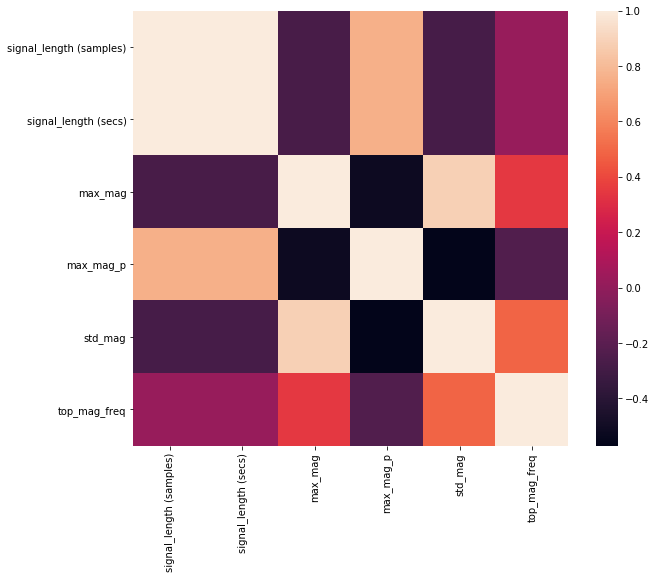

In [45]:
import seaborn as sns # Seaborn is just a prettier plotting library

plt.figure(figsize=(10, 8))
sns.heatmap(corr, square=True);

We can also plot a "prettier" version of the correlation matrix (that also takes advantage of its symmetry by only showing one side).

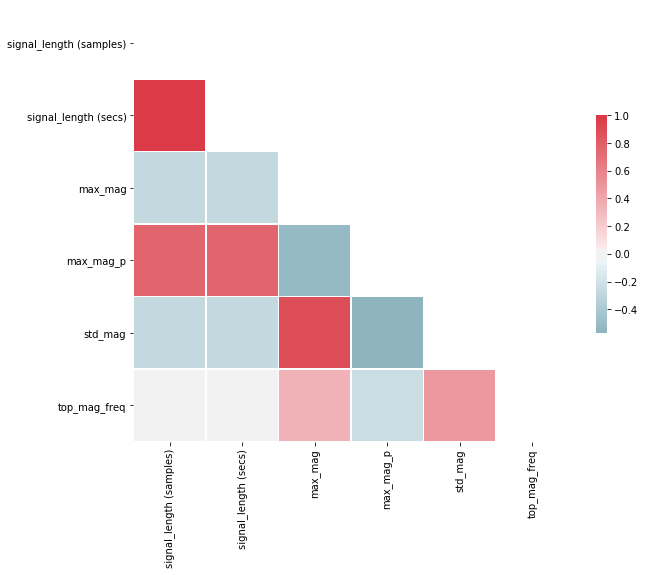

In [46]:
# Plot a "pretty" version of the correlation matrix 
# Based on: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Given that the correlation table is symmetrical, we remove one side 

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Classification 

Whew—and to think, we haven't even made it to classification yet!

But it's important to focus on selecting good features because even the most advanced classifiers won't work without good training examples.

Below, we will walk through an entire end-to-end classification example with Scikit-learn using a selected gesture set.

## Feature extraction code

Now that we've explored some features, you can add in some promising features to the method `extract_features_from_trial`, which our classifiers will use below.

This is where you spend quite a bit of time adding, subtracting, and manipulating input features for your model.

In [ ]:
def extract_features_from_gesture_set(gesture_set):
    '''
    Extracts features from the gesture set
    '''
    list_of_feature_vectors = []
    column_headers = None
    for gesture_name in gesture_set.get_gesture_names_sorted():
        gesture_trials = gesture_set.map_gestures_to_trials[gesture_name]
        #print(gesture_name, gesture_trials)
        for trial in gesture_trials:
            features, feature_names = extract_features_from_trial(trial)
             
            # add in bookkeeping like gesture name and trial num
            # you shouldn't need to modify this part
            features.append(gesture_set.get_base_path())
            feature_names.append("gesturer")

            features.append(gesture_name)
            feature_names.append("gesture")

            features.append(trial.trial_num)
            feature_names.append("trial_num")
    
            list_of_feature_vectors.append(features)
        
            if column_headers is None:
                column_headers = feature_names
    return (list_of_feature_vectors, column_headers)

def extract_features_from_trial(trial):
    '''Returns a tuple of two lists (a list of features, a list of feature names)'''
    
    # Play around with features to extract and use in your model
    # Brainstorm features, visualize ideas, try them, and iterate
    # This is likely where you will spend most of your time :)
    # This is the "feature engineering" component of working in ML
    features = []
    feature_names = []
    
    # TODO: you may or may not want to keep these features
    # I just added them as examples! :)
    features.append(np.max(trial.accel.mag)) # append feature
    feature_names.append("mag.max()")        # add in corresponding name
    
    features.append(np.std(trial.accel.mag))
    feature_names.append("std(mag.max())")
    
    features.append(len(trial.accel.mag))
    feature_names.append("signal_length")
    
    features.append(extract_feature_top_mag_freq2(trial.accel))
    feature_names.append("top_mag_freq")
    
    # TODO:
    # This is where you add in your new features to train the model
    
    return (features, feature_names)

## Building an initial classifier

Alright, let's build an initial feature-based, supervised learning classifier for our gesture data. For this example, we will use a [Support Vector Machine (SVM)](https://scikit-learn.org/stable/modules/svm.html), a popular machine learning approach often used in gesture classification. (But other classification models are also possible, which we will show later. Thankfully, Scikit-learn is setup rather beautifully to enable us to swap in and out different classification models and parameters).

### Extract our features

First, let's run our feature extraction code and setup a Pandas DataFrame.

In [ ]:
# Extract our features

# Set the selected gesture set. We'll start with my gesture set but you can loop around
# and play with your own
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")

(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

# We'll convert the feature vector and feature names lists into Pandas tables
# which simply makes interacting with Scikit-learn easier
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

# We don't want the trial number or gesturer to be an input feature, so remove
trial_indices = df.pop("trial_num") 
gesturer = df.pop('gesturer')
y = df.pop('gesture')

# Scikit-learn documentation consistently refer to the input feature table as X
# and the ground truth labels for this table as either y or y_true. We'll 
# use the same naming conventions
X = df

# Display the feature vector table and ground truth labels
print(f"Selected gesture set: {selected_gesture_set.name}")
display_tables_side_by_side(df, pd.DataFrame(y), n = 8, 
                            df1_caption = "Features", df2_caption = "Ground truth labels")

### Creating the classifier model

As previously noted, we will use an SVM for this example. As [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine) notes, "Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other". More specifically, an SVM constructs a "hyper-plane" that attempts to divide input features along a decision boundary. The samples along this decision boundary are called the "support vectors" since they are "supporting" the limits of the hyper-plane. 

<center>
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_0011.png" width=500>
    <caption><smaller>This figure shows a binary classification with three samples on the decision boundary (the "support vectors")</smaller></caption>
</center>

For more information on SVMs, I recommend this approachable video by Alice Zhao entitled [Support Vector Machines: A Visual Explanation with Sample Python Code](https://youtu.be/N1vOgolbjSc).

I also suggest that you read through Scikit-learn's [Supervised Learning](https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html) tutorial.

So, let's do it!

In [ ]:
from sklearn import svm

# Create a basic SVM with a linear kernel
# See: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# Note: this simply instantiates the svm.SVC class and stores it in a var called clf
# it does not actually train and run the SVM (that comes later)
clf = svm.SVC(kernel='linear')

Yes, that's it. Rather anti-climatic, I know. Of course, there are many different types of SVM kernels (`linear`, `poly`) and also parameters to tune like a regularization factor called `C` and many other [things](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) (not to mention other [classifiers](https://scikit-learn.org/stable/supervised_learning.html)). You'll likely want to experiment and read about these parameters.

For now, however, let's just focus on getting the full classification framework setup.

### Setting up the experiment

How should we evaluate our classifier's performance? In the shape-matching assignment, we used k-fold cross validation but there are other approaches. 

In setting up our experiment, we want to ensure:
- That we properly split our data into training and test sets. Often, an easy mistake to make (for novices and experts alike) is to accidentally include some test data into the training set. This will artifically inflate performance. Scikit-learn's experimental frameworks guard against this.
- That we don't necessarily run only a single experiment on one arbitrary split of the data. This may also give us a distorted view of performance.

The most straightforward is called 

#### 80/20 Split

The simplest experimental setup is to divide your data into a training and test set (*e.g.,* 50% for training, 50% for test). A common split is 80% for training and 20% for testing. This is a bit like our previous k-fold approach but only doing one fold (and thus, is not as rigorous).

Scikit-learn has a built-in function for this aptly called [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [ ]:
from sklearn.model_selection import train_test_split

# 80/20 split with stratification
# in this case, we have 11 gestures x 5 samples = 55 total
# so, 20% of this is 11 samples. we want to stratify by gesture name so that we get 1 example of each
# gesture in our test set. if we don't have stratify on, we could end up with an imbalanced test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y)

print("The training data:")
#display(X_train)
display_tables_side_by_side(X_train, pd.DataFrame(y_train), df1_caption="Input features", df2_caption="Class")

print("The test data:")
display_tables_side_by_side(X_test, pd.DataFrame(y_test), df1_caption="Input features", df2_caption="Class")

#### Basic k-fold cross validation

In the [shape-matching assignment](https://makeabilitylab.github.io/physcomp/signals/gesturerec/shapebased/index.html), you implemented your own k-fold cross validation algorithm. While we didn't emphasize this then, your k-fold implementation was a type of **stratified** k-fold in that your folds guarantteed one sample of each class in each fold.

A more general k-fold implementation is class agnostic: it will split up your data randomly into five folds with no guarantees about class representation.

We can use [`sklearn.model_selection.KFold(n_splits=5, *, shuffle=False, random_state=None)`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) for this, which takes in:
- **n_splits**: Number of folds. Must be at least 2. Defaults to 5.
- **shuffle**: Whether to shuffle the data before splitting into folds.
- **random_state**: Controls how to shuffle the data. If you want to repeat the same random shuffling, pass in an **int** to be used as the random seed.

Let's take a look.

In [ ]:
from sklearn.model_selection import KFold

kf_cross_validator = KFold(n_splits=5, shuffle=True)
display_folds(kf_cross_validator, X, y, trial_indices)

But the problem with a basic k-fold cross validation, at least for our purposes, is that we want to ensure that the "correct answer" is *always* in a test fold (and this is relatively easy to accomplish because we have a perfectly balanced dataset of five samples per class). The basic KFold model doesn't do this.

So, what do we do? Enter: stratified k-fold cross validation. This is very similar to what you implemented in your last assignment.

#### Stratified k-fold cross validation

A [stratified k-fold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) creates folds that preserve the percentange of samples for each class (and again, we have a perfectly balanced dataset, so 20% of each class—or one sample—will go in each fold.)

Fortunately, and quite elegantly, the [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) API is the same as for regular [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold): `sklearn.model_selection.StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None)`.

Let's try it out.

If things work the way they should, then we will have one sample of each class in each fold. Take a careful look at the output table.

In [49]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True)
display_folds(skf, X, y, trial_indices)

Fold 0                          Fold 1  \
0                        At Rest 1                       At Rest 2   
1                Backhand Tennis 3               Backhand Tennis 0   
2                 Baseball Throw 1                Baseball Throw 0   
3                         Custom 1                        Custom 0   
4                Forehand Tennis 0               Forehand Tennis 2   
5                     Midair 'S' 2                    Midair 'S' 0   
6           Midair Clockwise 'O' 1          Midair Clockwise 'O' 4   
7   Midair Counter-clockwise 'O' 3  Midair Counter-clockwise 'O' 1   
8               Midair Zorro 'Z' 0              Midair Zorro 'Z' 1   
9                          Shake 2                         Shake 4   
10             Underhand Bowling 2             Underhand Bowling 4   

                            Fold 2                          Fold 3  \
0                        At Rest 3                       At Rest 0   
1                Backhand Tennis 4               Backhand Tennis 2   
2                 Baseball Throw 4                Baseball Throw 2   
3                         Custom 4                        Custom 2   
4                Forehand Tennis 4               Forehand Tennis 3   
5                     Midair 'S' 4                    Midair 'S' 1   
6           Midair Clockwise 'O' 3          Midair Clockwise 'O' 0   
7   Midair Counter-clockwise 'O' 4  Midair Counter-clockwise 'O' 0   
8               Midair Zorro 'Z' 2              Midair Zorro 'Z' 3   
9                          Shake 0                         Shake 3   
10             Underhand Bowling 3             Underhand Bowling 0   

                            Fold 4  
0                        At Rest 4  
1                Backhand Tennis 1  
2                 Baseball Throw 3  
3                         Custom 3  
4                Forehand Tennis 1  
5                     Midair 'S' 3  
6           Midair Clockwise 'O' 2  
7   Midair Counter-clockwise 'O' 2  
8               Midair Zorro 'Z' 4  
9                          Shake 1  
10             Underhand Bowling 1

It worked!

#### Playing with shuffle and random state

It's often best to shuffle our folds randomly to setup our validation experiment; however, to control for reproducibility—for example, to use the same split across multiple executions (say, if you changed a preprocessing algorithm and wanted to evaluate its impact)—Scikit-learn allows you to manipulate how the random split occurs. Most simply, by passing in an `int`, which will be used as the random seed for the split. The same `int` will always produce the same split.

Let's check it out!

In [ ]:
# Rerun this cell and you'll get new random splits every time
skf = StratifiedKFold(n_splits=5, shuffle=True)
display_folds(skf, X, y, trial_indices)

In [ ]:
# Rerun this cell and you'll get the same splits every time
kfold_seed = 3 # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)
display_folds(skf, X, y, trial_indices)

### Running the experiment

Finally, we are ready to run our classification experiment using cross-validation.

#### Using cross_val_score

Let's start with the simplest way to this, using [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), which takes in (among other things):
- **estimator**: A classifier, which Scikit-learn calls more generally an estimator (because their framework works with regression problems as well as classification problems). Recall that we instantiated an SVM model and stored it in the `clf` variable (the SVM has yet to be trained, that's what this step does).
- **X**: our input features
- **y**: the class labels
- **cv**: the cross validation model, which we previously created as a `StratifiedKFold` and stored it in `skf`

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=skf)
print("Fold scores:", scores)
print("Overall: {:.2f}%".format(np.mean(scores) * 100))

Not bad, huh? 65.5% accuracy with just a few simple features. And you'll be able to do much better once you add in more thoughtful features.

#### Using cross_validate

Let's use the [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function instead of `cross_val_score` to produce more detailed performance results like how long each training and testing step took (called `fit_time` and `score_time`, respectively). 

Noticeably, the SVM is much faster to train and test than our shape-based models from before!

In [ ]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(clf, X, y, cv=skf, return_train_score=False)
print(cv_results)

Beautify into a Pandas DataFrame table.

In [ ]:
display(pd.DataFrame(cv_results))
print(f"Overall average: {np.mean(cv_results['test_score']):.3f} (SD={np.std(cv_results['test_score']):0.3f})")

#### Using cross_val_predict

Perhaps the most useful experimental validation method, however, is [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html), which returns a prediction array that we can use to compute additional performance statistics.

In [ ]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(clf, X, y, cv=skf)
print(y_pred)

With the `y_pred` array, you can now use other metrics like accuracy_score, confusion matrix, *etc.*

In [ ]:
from sklearn.metrics import accuracy_score

overall_acc = accuracy_score(y, y_pred)
print(f"{overall_acc * 100:0.2f}%")

#### Classification report

With the `y_pred` array, we can build a [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

#### Build a confusion matrix

Now let's build our friendly, helpful confusion matrices!

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
print(cm)

Beautify the confusion matrix:

In [ ]:
import sklearn.metrics

cm_title = f"SVM {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=cm_title)

### Scaling our input features

A final but no less important step—which we skipped over above simply to provide a straightforward example—is that many classifiers (including an SVM) are sensitive to feature scaling. That is, performance varies dramatically if all input features are not normalized.

Fortunately, Scikit-learn has a solution but it does introduce a bit of complexity: namely, we shift from using our core classifier model `clf` to a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object, which takes in a list of "steps" and executes them sequentially where steps can include preprocessing, transforming, and eventually classifying an input.

Importantly, Scikit-learn "learns" a feature-scaling model for each feature from the *training* set and applies it to the test set. 

If you're curious about preprocessing data, in general, for machine learning, we suggest Scikit-learn's article on [preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) and the Wikipedia article on [Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling).



#### Using a StandardScaler

We'll show how to use one normalization method with Scikit-learn: [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which standardizes features by removing the mean and scaling to unit variance. As expected, this results in a performance increase.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create the transform class
scaler = StandardScaler()

# Create the pipeline object. Scikit-learn will execute these objects in sequence
# and use the output from one to the other
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

# Now use cross_val_predict with our pipeline object vs. clf
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("SCALED RESULTS: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | Scaled Features SVM {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

## Full SVM example (redux)

OK, let's do that again but this time in a single cell (so it's easier to see how everything fits together). And let's pick a different gesture set this time as well.

In [ ]:
print(f"We have {len(map_gesture_sets)} gesture sets:")
for gesture_set_name, gesture_set in map_gesture_sets.items():
    print(f" {gesture_set_name} with {len(gesture_set.get_all_trials())} trials")

# Feel free to change the selected_gesture_set. It's just a convenient variable
# to explore one gesture set at a time
print(f"The selected gesture set is currently: {selected_gesture_set.name}")

In [ ]:
# Grab a gesture set. I'm using "Justin" but feel free to play with any others, including your own (obviously!)
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")

(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

# We'll convert the feature vector and feature names lists into Pandas tables
# which simply makes interacting with Scikit-learn easier
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

# We don't want the trial number or gesturer to be an input feature, so remove
trial_indices = df.pop("trial_num") 
gesturer = df.pop('gesturer')
y = df.pop('gesture')

# Scikit-learn documentation consistently refer to the input feature table as X
# and the ground truth labels for this table as either y or y_true. We'll 
# use the same naming conventions
X = df

kfold_seed = 3 # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)

clf = svm.SVC(kernel='linear', C=0.4)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

print(f"Results for {selected_gesture_set.name}")
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall SVM accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | SVM {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

## Experimenting with other classifiers

By now, hopefully, you've realized the breadth and depth of the Scikit-learn library—and again, we've only touched on a small number of possibilities. Before we complete this introduction, we wanted to emphasize one other architectural delight: the various Scikit-learn classifiers have the same basic API and so can be easily swapped and compared with one another (indeed, you can even design and implement your own classifier class if you'd like).

We'll just quickly show two other common classifiers: [k-nearest neighbors (kNN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) and a [decision tree](https://scikit-learn.org/stable/modules/tree.html).

### kNN classifier
For background on nearest neighbor approaches, read Scikit-learn's [overview](https://scikit-learn.org/stable/modules/neighbors.html).

In [62]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

print(f"Results for {selected_gesture_set.name}")
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall kNN accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | kNN {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

NameError: name 'StandardScaler' is not defined

### Decision tree classifier
For background on decision trees, read Scikit-learn's [overview](https://scikit-learn.org/stable/modules/tree.html).

In [63]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

print(f"Results for {selected_gesture_set.name}")
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall kNN accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | kNN {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

NameError: name 'StandardScaler' is not defined

# My Model Predictions

## Extraction code

In [64]:
def extract_features_from_gesture_set(gesture_set):
    '''
    Extracts features from the gesture set
    '''
    list_of_feature_vectors = []
    column_headers = None
    for gesture_name in gesture_set.get_gesture_names_sorted():
        gesture_trials = gesture_set.map_gestures_to_trials[gesture_name]
        #print(gesture_name, gesture_trials)
        for trial in gesture_trials:
            features, feature_names = extract_features_from_trial(trial)
             
            # add in bookkeeping like gesture name and trial num
            # you shouldn't need to modify this part
            features.append(gesture_set.get_base_path())
            feature_names.append("gesturer")

            features.append(gesture_name)
            feature_names.append("gesture")

            features.append(trial.trial_num)
            feature_names.append("trial_num")
    
            list_of_feature_vectors.append(features)
        
            if column_headers is None:
                column_headers = feature_names
    return (list_of_feature_vectors, column_headers)

def extract_features_from_trial(trial):
    '''Returns a tuple of two lists (a list of features, a list of feature names)'''
    
    # Play around with features to extract and use in your model
    # Brainstorm features, visualize ideas, try them, and iterate
    # This is likely where you will spend most of your time :)
    # This is the "feature engineering" component of working in ML
    features = []
    feature_names = []
    
    # TODO: you may or may not want to keep these features
    # I just added them as examples! :)
    features.append(np.max(trial.accel.mag)) # append feature
    feature_names.append("mag.max()")        # add in corresponding name
    
#     features.append(np.std(trial.accel.mag))
#     feature_names.append("std(mag.max())")
    
    features.append(len(trial.accel.mag))
    feature_names.append("signal_length")
    
    features.append(extract_feature_top_mag_freq2(trial.accel))
    feature_names.append("top_mag_freq")
    
    # Features I'm adding:
    
#     # 1. Signal Mean Magnitude
#     features.append(extract_feature_mean_mag(trial.accel))
#     feature_names.append("signal_mean_mag")
    
    # 2. Standard Deviation of Y Axis
    features.append(extract_feature_stdev_y(trial.accel))
    feature_names.append("signal_stdev_y")
    
#     # 3. Number of Signal Peaks, Y Axis
#     peak_prominence=5
#     features.append(extract_feature_peaks_avg_horiz_dist_z_p(trial.accel))
#     feature_names.append("num_signal_peaks")
    
#     # 4. Lowest Frequency in Signal
#     features.append(extract_feature_lowest_freq_over_thresh(trial.accel))
#     feature_names.append("lowest_freq")
    
#     # 5. Avg value of frequencies in Signal
#     features.append(extract_feature_avg_val_freq_over_thresh(trial.accel))
#     feature_names.append("avg_val_frequencies")
    
#     # 6. Number of Frequencies in Signal
#     features.append(extract_feature_num_freq_over_thresh(trial.accel))
#     feature_names.append("num_frequencies")
    
    
    return (features, feature_names)

## SVM Model

In [65]:
# Grab a gesture set. I'm using "Justin" but feel free to play with any others, including your own (obviously!)
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Dustin")

(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

# We'll convert the feature vector and feature names lists into Pandas tables
# which simply makes interacting with Scikit-learn easier
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

# We don't want the trial number or gesturer to be an input feature, so remove
trial_indices = df.pop("trial_num") 
gesturer = df.pop('gesturer')
y = df.pop('gesture')

# Scikit-learn documentation consistently refer to the input feature table as X
# and the ground truth labels for this table as either y or y_true. We'll 
# use the same naming conventions
X = df

kfold_seed = 3 # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)

clf = svm.SVC(kernel='rbf', C=0.4)

scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

print(f"Results for {selected_gesture_set.name}")
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall SVM accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | SVM {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

NameError: name 'svm' is not defined

## kNN Model

### Feature Extraction Code

In [66]:
def extract_features_from_gesture_set(gesture_set):
    '''
    Extracts features from the gesture set
    '''
    list_of_feature_vectors = []
    column_headers = None
    for gesture_name in gesture_set.get_gesture_names_sorted():
        gesture_trials = gesture_set.map_gestures_to_trials[gesture_name]
        #print(gesture_name, gesture_trials)
        for trial in gesture_trials:
            features, feature_names = extract_features_from_trial(trial)
             
            # add in bookkeeping like gesture name and trial num
            # you shouldn't need to modify this part
            features.append(gesture_set.get_base_path())
            feature_names.append("gesturer")

            features.append(gesture_name)
            feature_names.append("gesture")

            features.append(trial.trial_num)
            feature_names.append("trial_num")
    
            list_of_feature_vectors.append(features)
        
            if column_headers is None:
                column_headers = feature_names
    return (list_of_feature_vectors, column_headers)

def extract_features_from_trial(trial):
    '''Returns a tuple of two lists (a list of features, a list of feature names)'''
    
    # Play around with features to extract and use in your model
    # Brainstorm features, visualize ideas, try them, and iterate
    # This is likely where you will spend most of your time :)
    # This is the "feature engineering" component of working in ML
    features = []
    feature_names = []
    
    # TODO: you may or may not want to keep these features
    # I just added them as examples! :)
    features.append(np.max(trial.accel.mag)) # append feature
    feature_names.append("mag.max()")        # add in corresponding name
    
#     features.append(np.std(trial.accel.mag))
#     feature_names.append("std(mag.max())")
    
    features.append(len(trial.accel.mag))
    feature_names.append("signal_length")
    
    features.append(extract_feature_top_mag_freq2(trial.accel))
    feature_names.append("top_mag_freq")
    
    # Features I'm adding:
    
#     # 1. Signal Mean Magnitude
#     features.append(extract_feature_mean_mag(trial.accel))
#     feature_names.append("signal_mean_mag")
    
    # 2. Standard Deviation of Y Axis
    features.append(extract_feature_stdev_y(trial.accel))
    feature_names.append("signal_stdev_y")
    
    # 333. Standard Deviation of Max Magnitude
    features.append(np.std(np.max(trial.accel.mag))) # append feature
    feature_names.append("std_mag_max")        # add in corresponding name
    
    ## 444. Magnitude of the Most Common Frequency
#     mag.top_freq
    
    ## 555. TO DO
#     mag_p.fd.num_peaks
    
    # 666. TO DO
#     mag_p.td.num_peaks
    
#     # 7. Number of Signal Peaks, Y Axis
#     peak_prominence=5
#     features.append(extract_feature_peaks_avg_horiz_dist_z_p(trial.accel))
#     feature_names.append("num_signal_peaks")
    
    # 8. Lowest Frequency in Signal
    features.append(extract_feature_lowest_freq_over_thresh(trial.accel))
    feature_names.append("lowest_freq")
    
#     # 9. Avg value of frequencies in Signal
#     features.append(extract_feature_avg_val_freq_over_thresh(trial.accel))
#     feature_names.append("avg_val_frequencies")
    
#     # 10. Number of Frequencies in Signal
#     features.append(extract_feature_num_freq_over_thresh(trial.accel))
#     feature_names.append("num_frequencies")
    
    
    return (features, feature_names)

### Model Code

In [67]:
# Grab a gesture set. I'm using "Justin" but feel free to play with any others, including your own (obviously!)
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")

(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

# We'll convert the feature vector and feature names lists into Pandas tables
# which simply makes interacting with Scikit-learn easier
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

# We don't want the trial number or gesturer to be an input feature, so remove
trial_indices = df.pop("trial_num") 
gesturer = df.pop('gesturer')
y = df.pop('gesture')

# Scikit-learn documentation consistently refer to the input feature table as X
# and the ground truth labels for this table as either y or y_true. We'll 
# use the same naming conventions
X = df

kfold_seed = 3 # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)

# clf = svm.SVC(kernel='rbf', C=0.4)
clf = KNeighborsClassifier(n_neighbors=3)


scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

print(f"Results for {selected_gesture_set.name}")
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall kNN accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | kNN {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

NameError: name 'StandardScaler' is not defined

# Cross-user classification

For your assignment, we would like you to build two cross-user models:
- The **first model** is trained on all users (the training set) except for one (the test set). Iterate through all users as test sets and report classification accuracies for each (in graph form) as well as overall accuracies (average accuracy across all users with standard deviation). To be clear, you are not running a standard k-fold cross validation here but instead a leave-one-out validation approach (where you leave one user out from the training set per classification experiment).

- For the **second cross-user model**, train again on *all* users but also four of the five gesture samples (of each gesture) from the target user. To simplify things, you need not run k-fold cross validation. You can simply randomly select four of five gesture samples (once). We expect that classification accuracies should increase here. Is that what happens?

Put your code and performance results below here.